In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))
from src.models import TadGAN, AttentionTadGAN
from src.processor import AnomalyDataset
from mlprimitives import load_primitive
from src.configuration.constants import REPORTS_DIRECTORY, MODELS_DIRECTORY
from orion.evaluation.contextual import contextual_f1_score, contextual_confusion_matrix
import pickle
import json

import numpy as np
import logging
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
def get_epoch_loss(source, dataset, signal, model_name):
    with open(os.path.join(MODELS_DIRECTORY, source, dataset, signal, model_name, 'input_parameters.json'), 'rb') as f:
        input_parameters = json.load(f)
    return np.array(input_parameters['epoch_loss'])
    

def plot_losses(tadgan_loss, attention_tadgan_loss, output_directory):
    fig, axs = plt.subplots(3, 4, figsize=(20, 10), sharey=False, sharex=True)

    epoch_loss_names = [
        ['valid_x_wasserstein_loss', 'fake_x_wasserstein_loss', 'partial_gp_loss_x', 'weighted_loss'],
        ['valid_z_wasserstein_loss', 'fake_z_wasserstein_loss', 'partial_gp_loss_z', 'weighted_loss'],
        ['fake_gen_x_wasserstein_loss', 'fake_gen_z_wasserstein_loss', 'mse', 'weighted_loss'],
    ]
    
    num_epoch, num_model, num_loss = tadgan_loss.shape

    index = [epoch for epoch in range(num_epoch)]
    for i in range(num_model):
        for j in range(num_loss):
            axs[i][j].set_title(epoch_loss_names[i][j])
            axs[i][j].plot(index, tadgan_loss[:, i, j], label='tadgan', color='b')
            axs[i][j].plot(index, attention_tadgan_loss[:, i, j], label='attention_tadgan', color='r')

    fig.suptitle(f'[{source}] [{dataset}] [{signal}] Epoch losses', fontsize=16)
    handles, labels = axs[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    fig.savefig(os.path.join(output_directory, 'epoch_losses.png'))

In [3]:
def get_anomalies(y_test, y_hat, critic, index_test):
    params = {"rec_error_type": "dtw", "comb": "mult"}

    primitive = load_primitive("orion.primitives.tadgan.score_anomalies", 
                               arguments=params)
    errors, true_index, true, predictions = primitive.produce(y=y_test, y_hat=y_hat, critic=critic, index=index_test)
    
    params = {
    "window_size_portion": 0.33, 
    "window_step_size_portion": 0.1,
    "fixed_threshold": True
    }

    primitive = load_primitive("orion.primitives.timeseries_anomalies.find_anomalies", 
                               arguments=params)
    predicted_anomalies = primitive.produce(errors=errors, index=true_index)
    predicted_anomalies = [(int(anomaly[0]), int(anomaly[1])) for anomaly in predicted_anomalies]
    return predicted_anomalies

def calculate_confusion_matrix(model_name, anomalies, y_test, index_test):
    output_directory = os.path.join(MODELS_DIRECTORY, source, dataset, signal, model_name)
    with open(os.path.join(output_directory, 'y_hat_test.npy'), 'rb') as f:
        y_hat = np.load(f)
    with open(os.path.join(output_directory, 'critic_test.npy'), 'rb') as f:
        critic = np.load(f)
    
    predicted_anomalies = get_anomalies(y_test, y_hat, critic, index_test)
    
    # true negative, false positive, false negative, true positive
    confusion_matrix = contextual_confusion_matrix(
        anomalies, 
        predicted_anomalies, 
        start=index_test[0], 
        end=index_test[-1], 
        weighted=False
    )
    return [predicted_anomalies, confusion_matrix]

  0%|          | 0/54 [00:00<?, ?it/s]

A-9


Using TensorFlow backend.


A-7
E-8
G-2
E-6
E-1
A-6
A-1
A-8
E-7
G-3
G-4
E-9
S-1
D-5
D-2
F-1
D-3
D-4
B-1
D-11


/Users/lcwong/opt/anaconda3/envs/hitlads-env/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


P-7
E-11
T-1
P-1
E-10
G-1
G-6
E-2
E-5
A-4
A-3
E-4
E-3
G-7
A-2
A-5
D-13
D-1
D-6
F-2
D-8
D-12
failed D-12
D-9
F-3
D-7
E-12
T-2
P-4
P-3
T-3
E-13
P-2
R-1


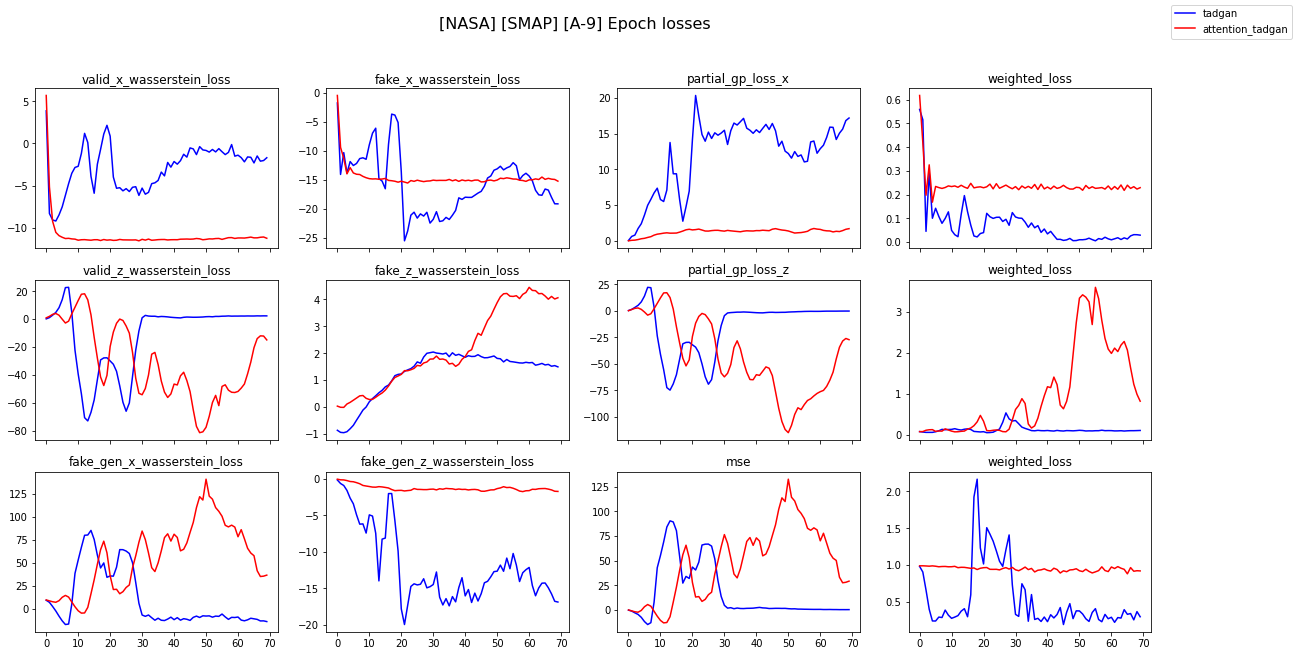

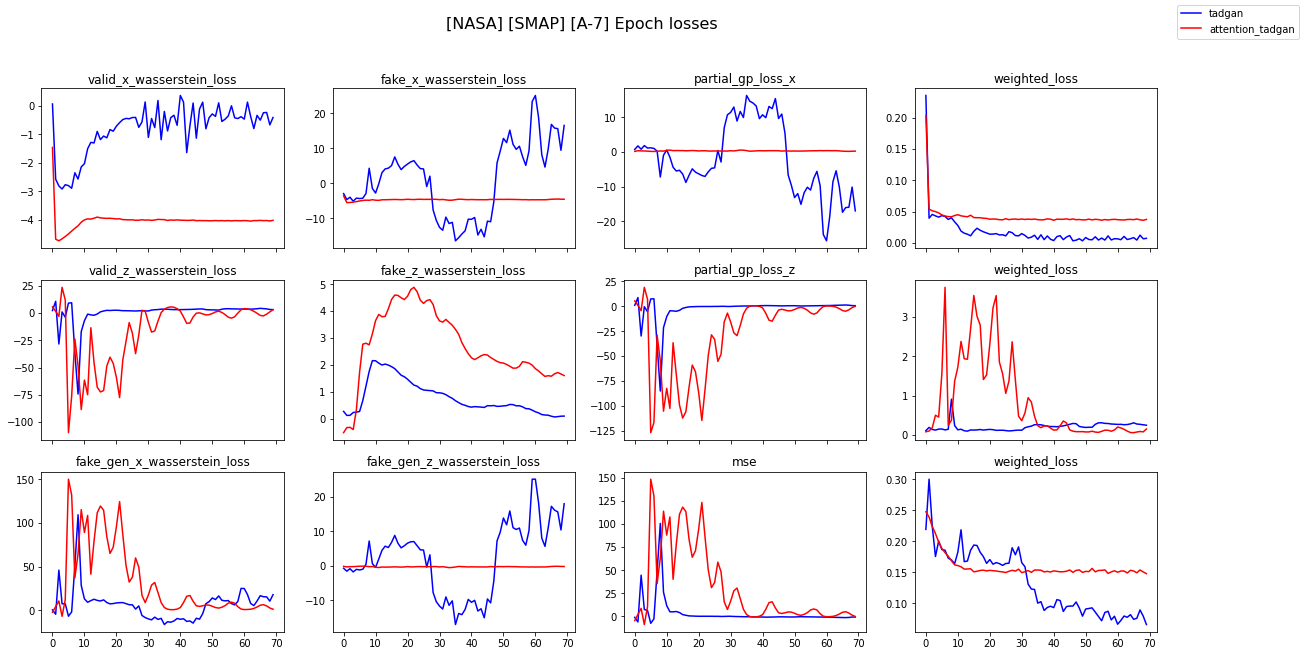

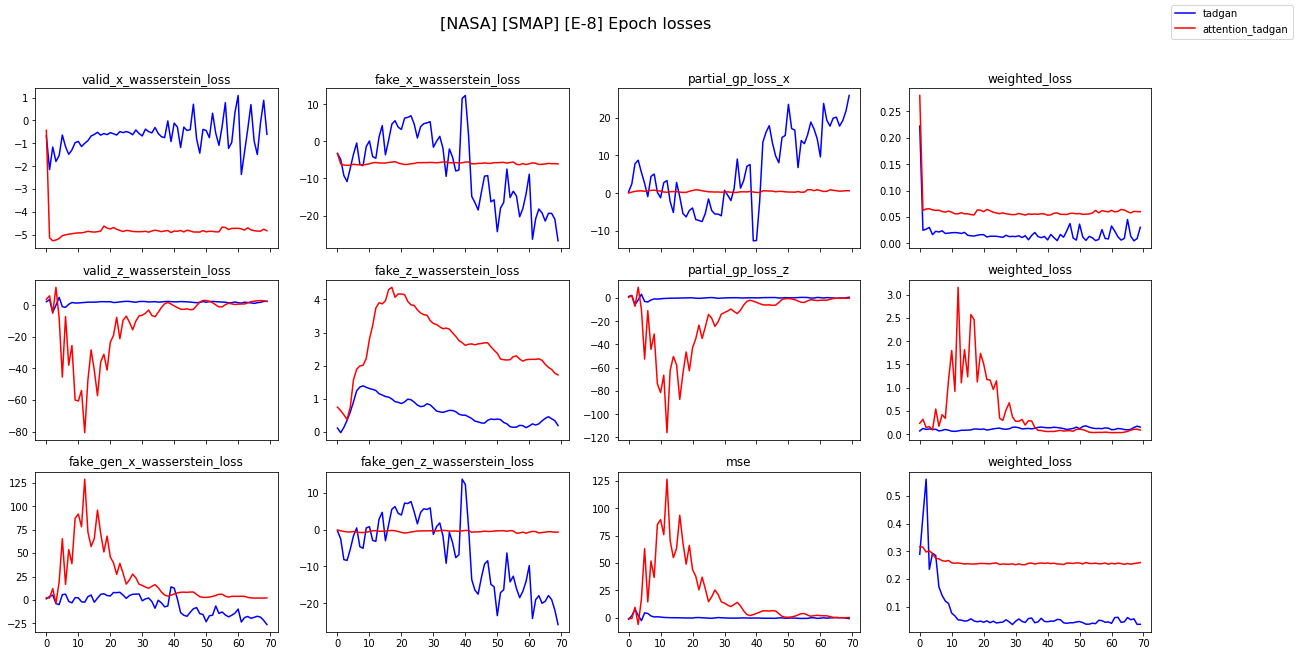

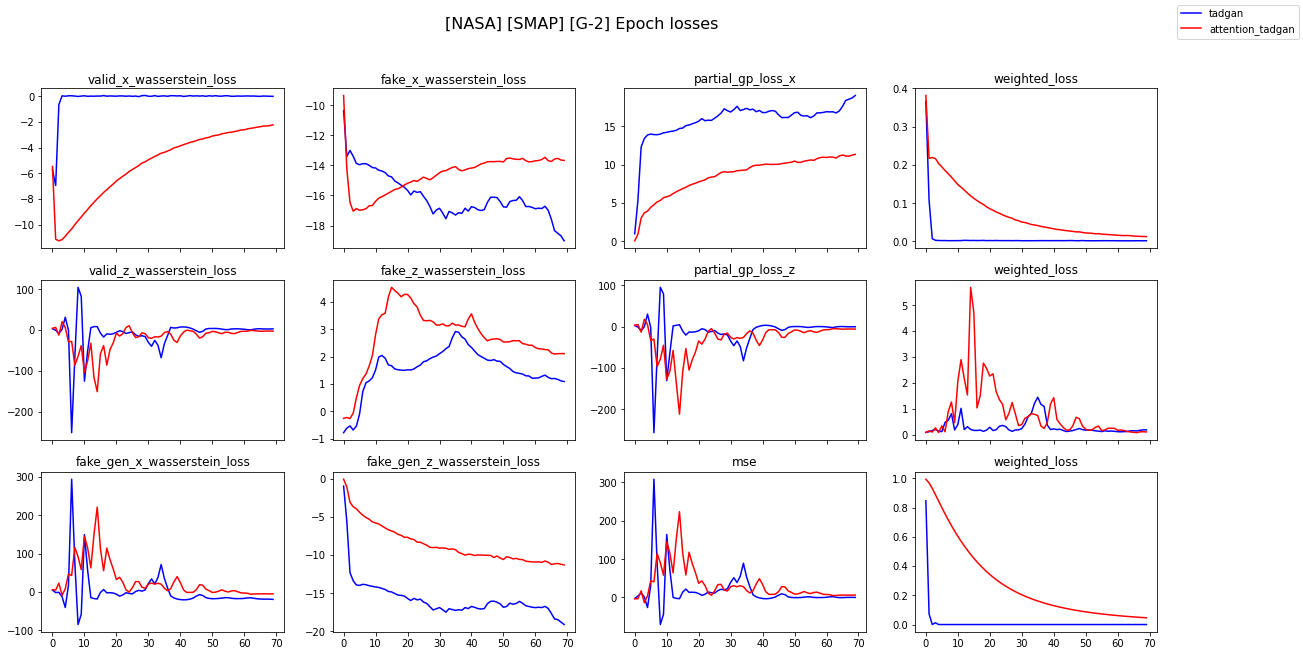

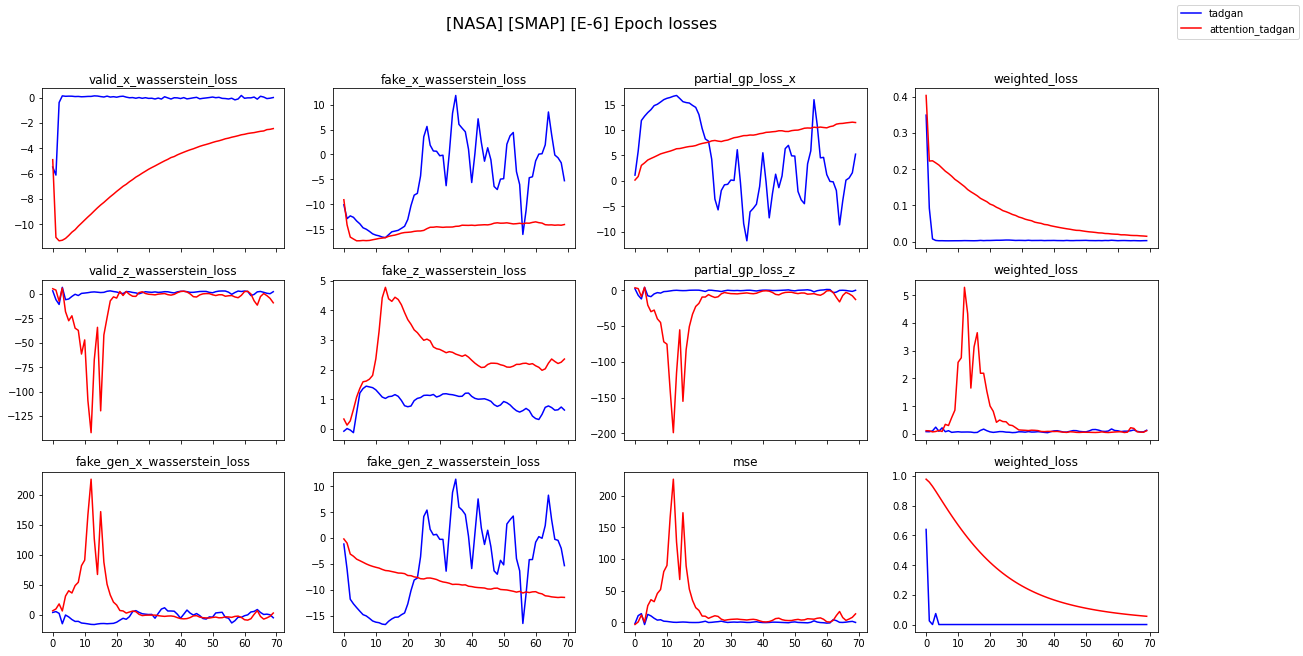

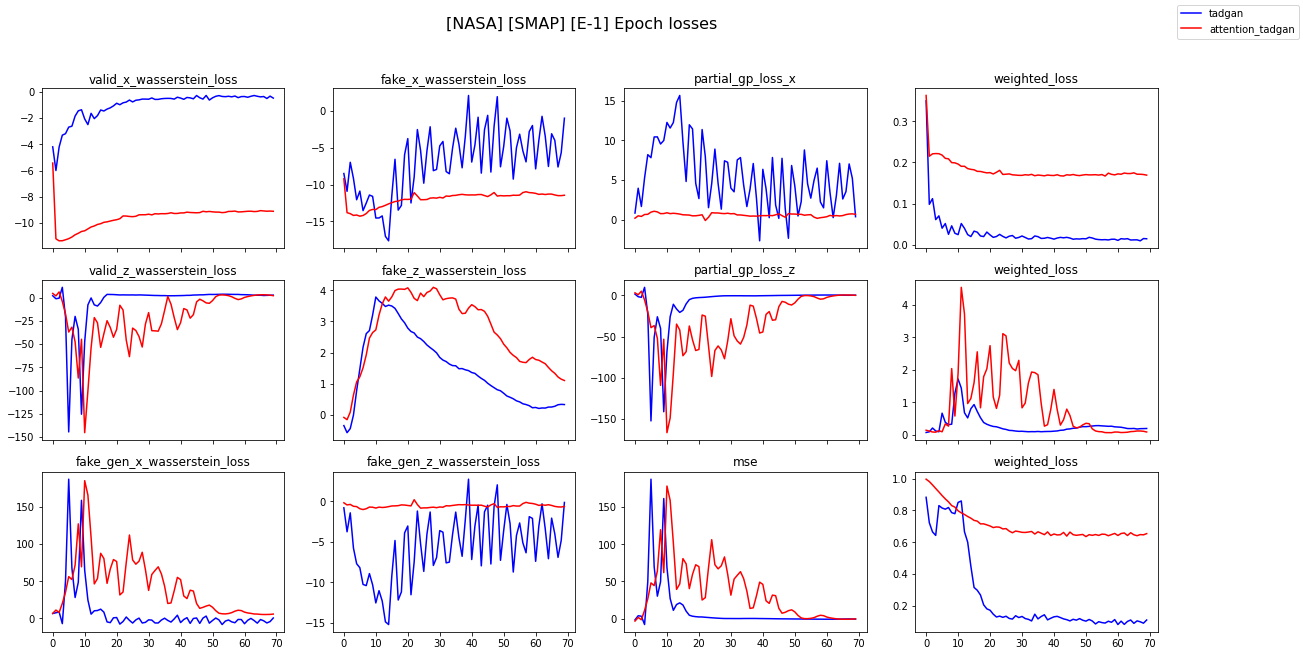

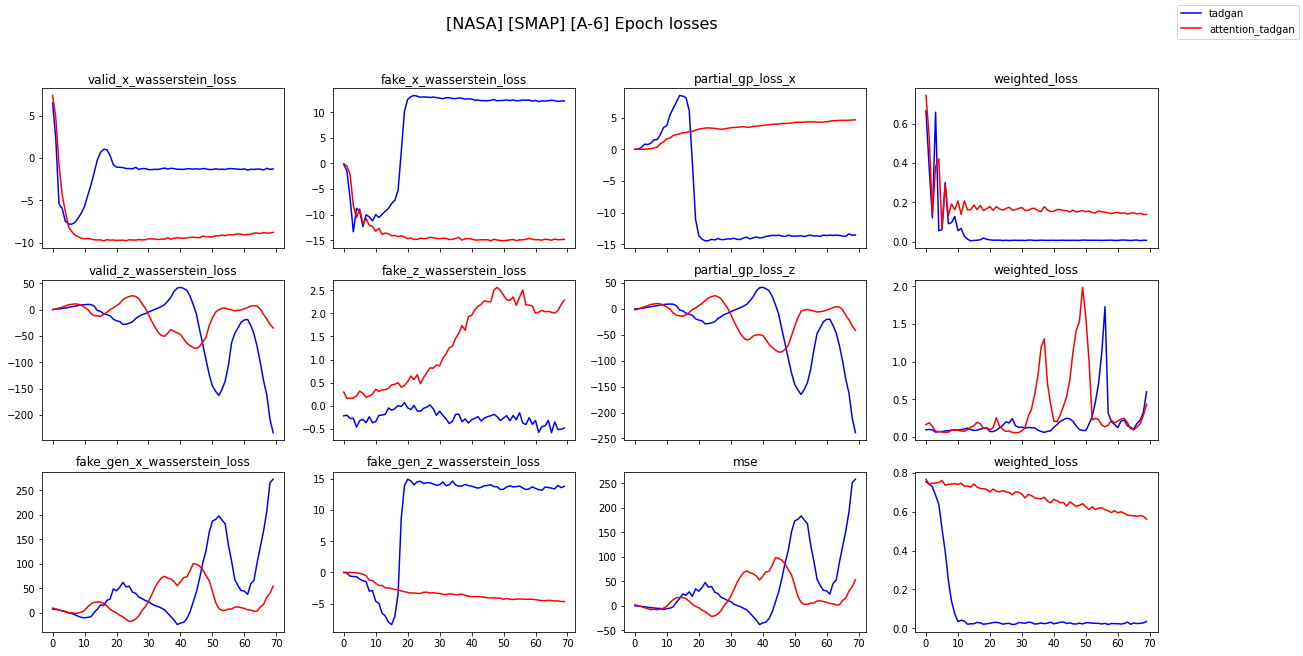

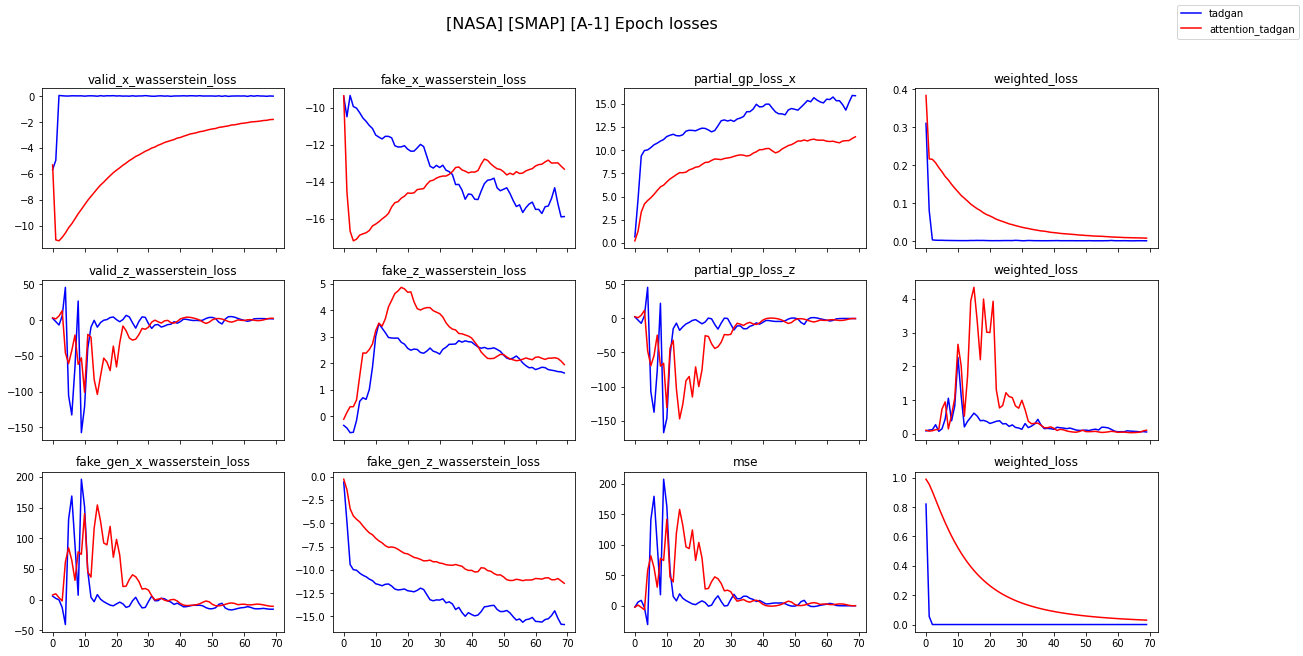

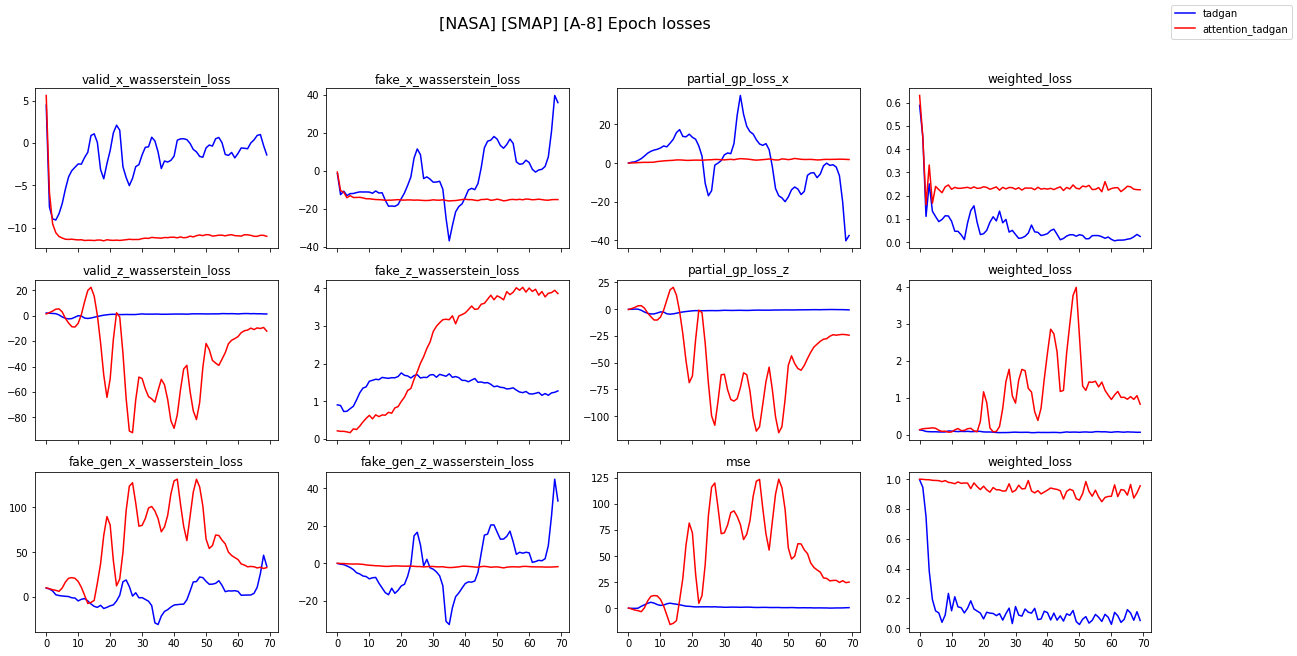

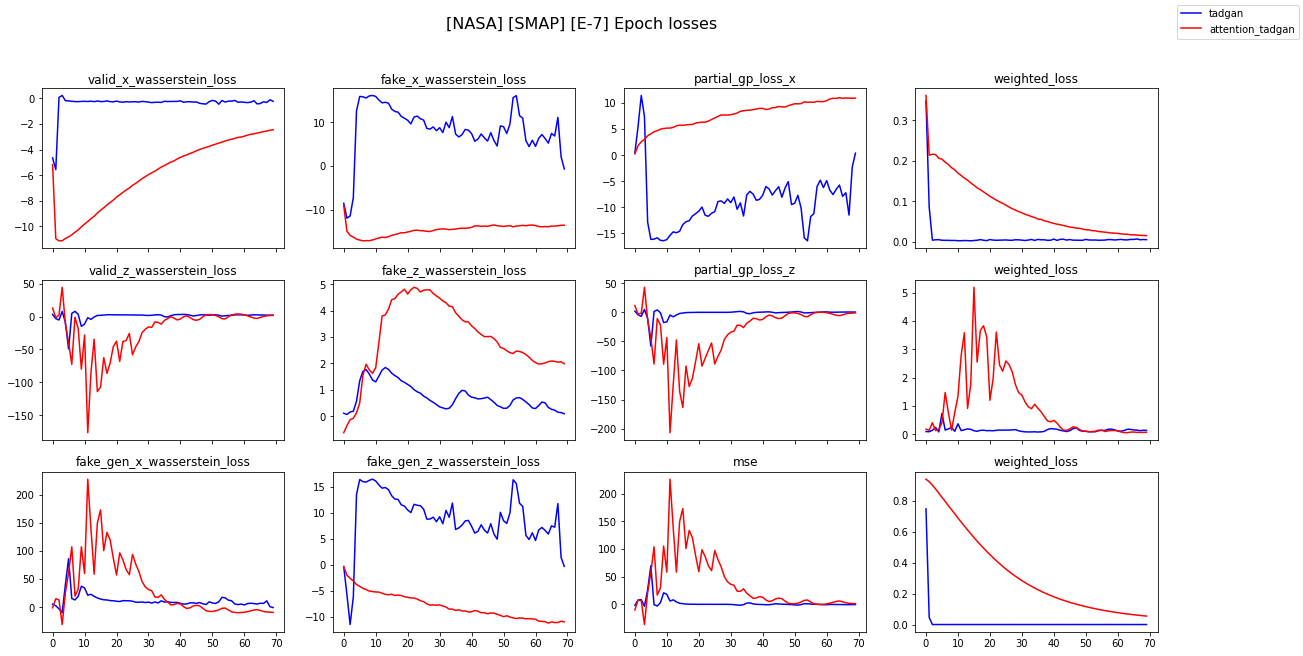

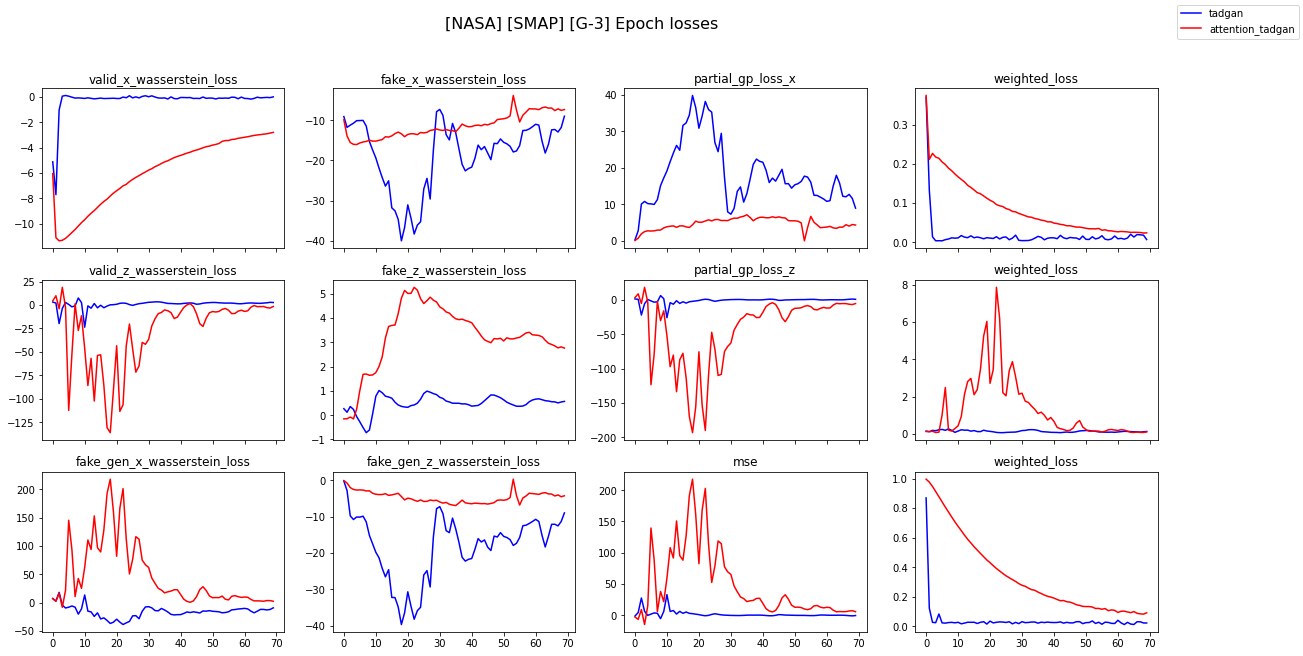

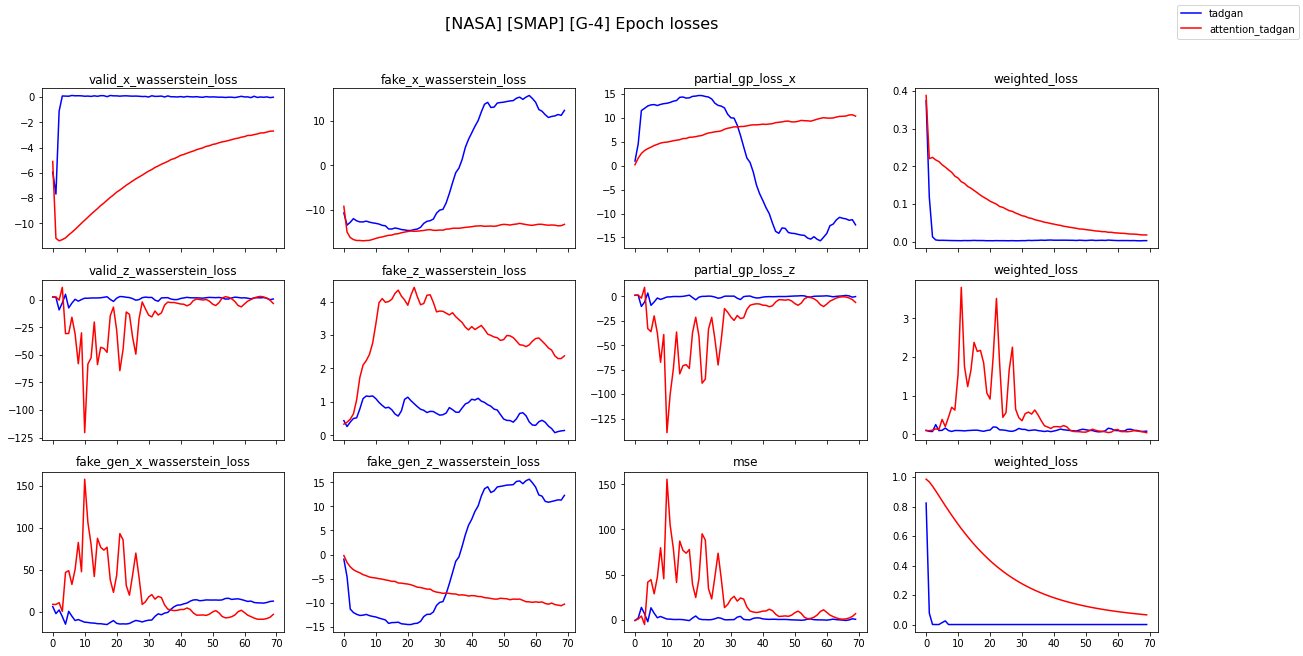

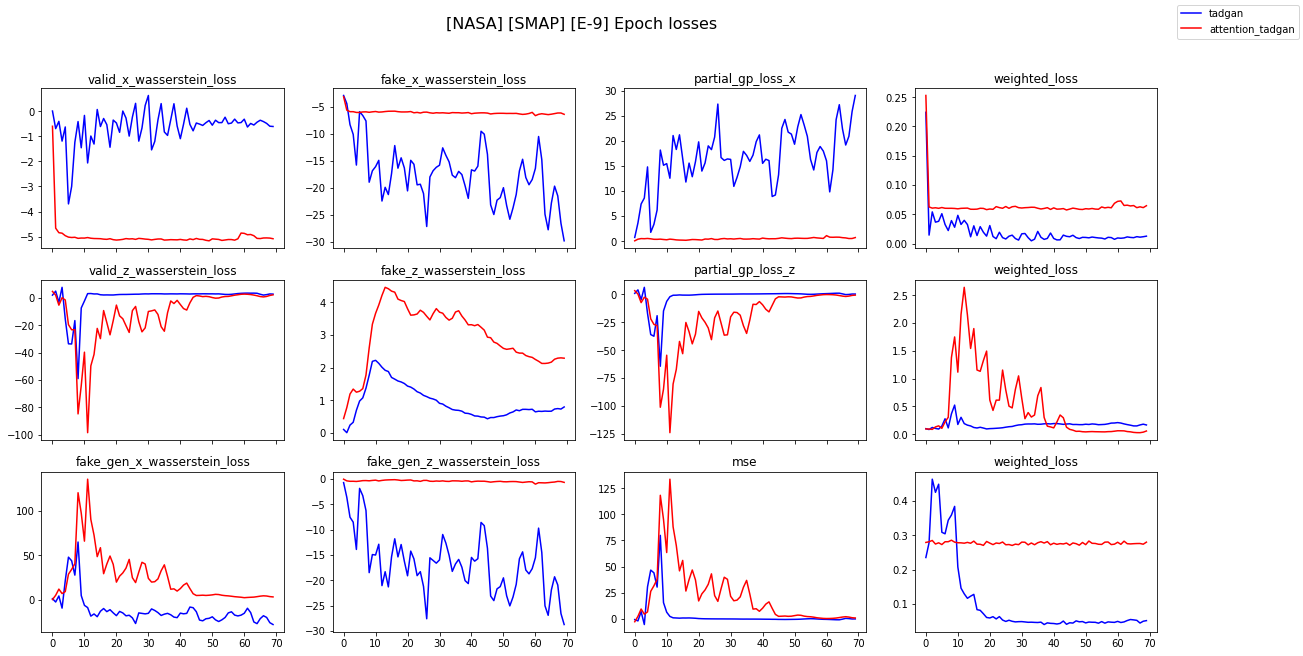

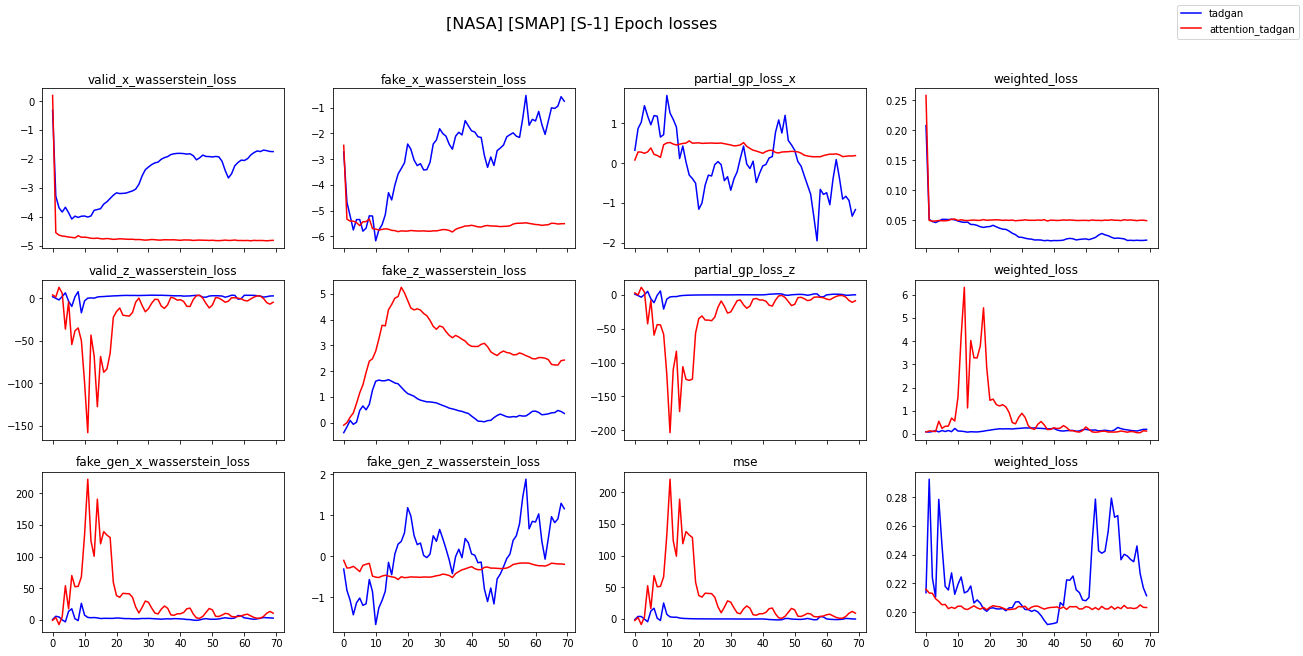

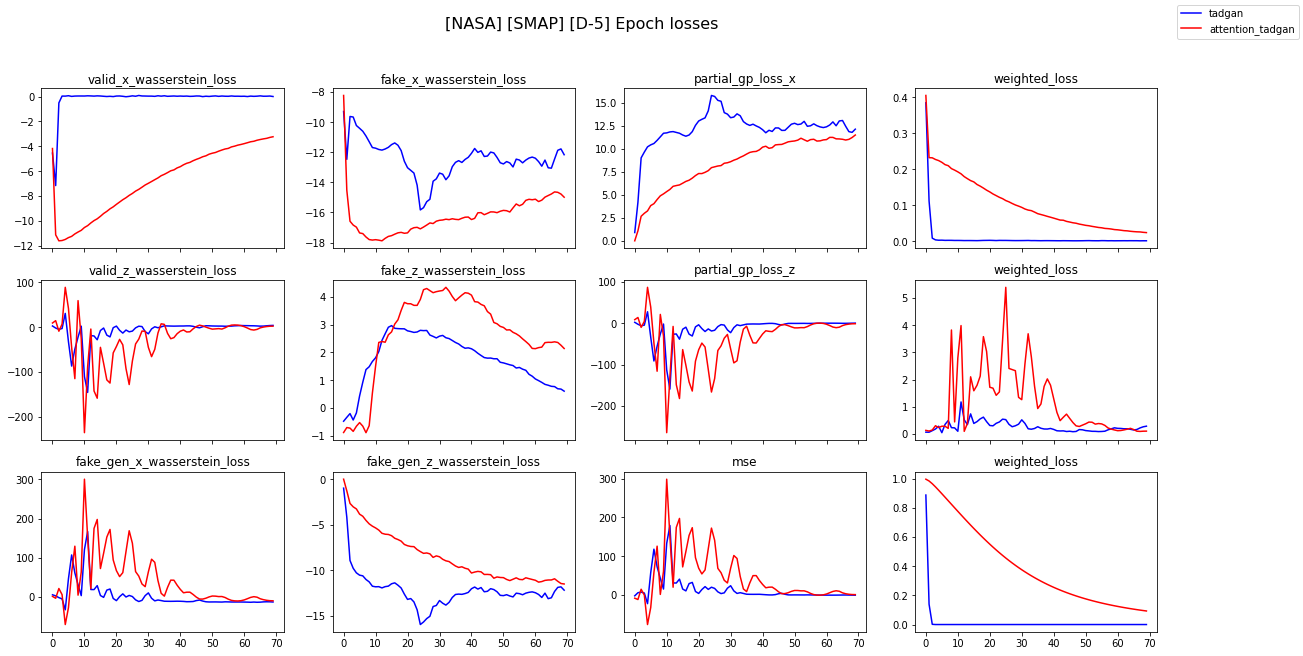

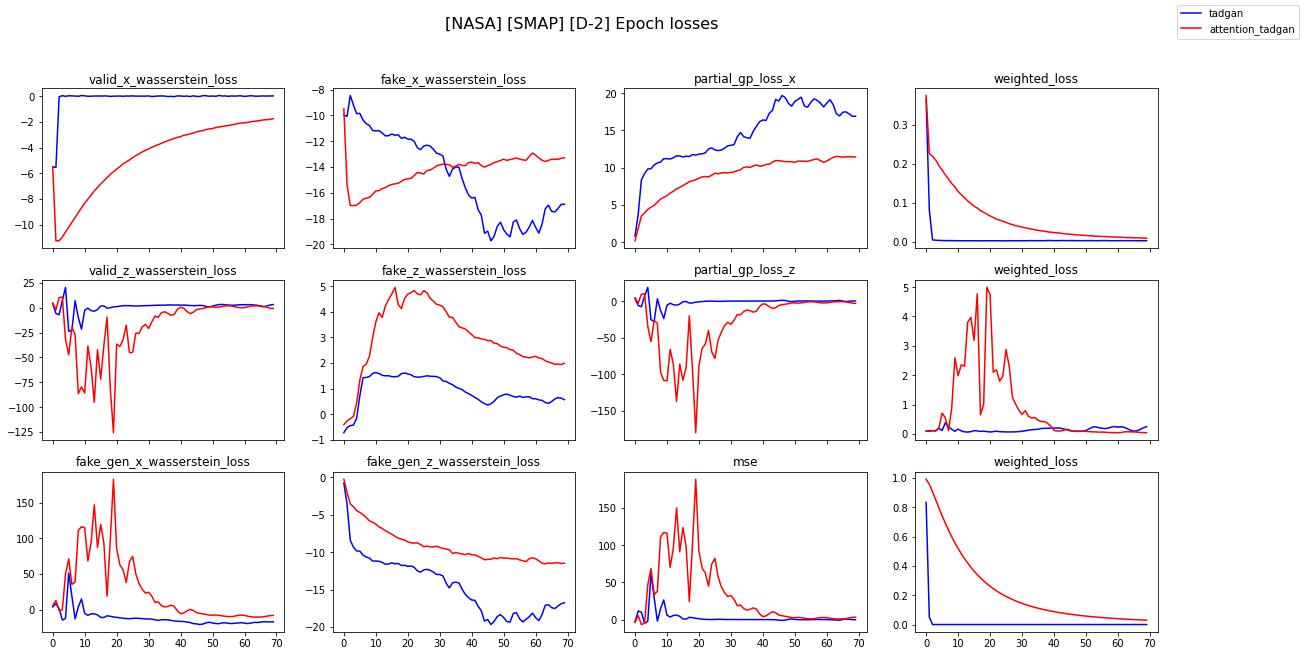

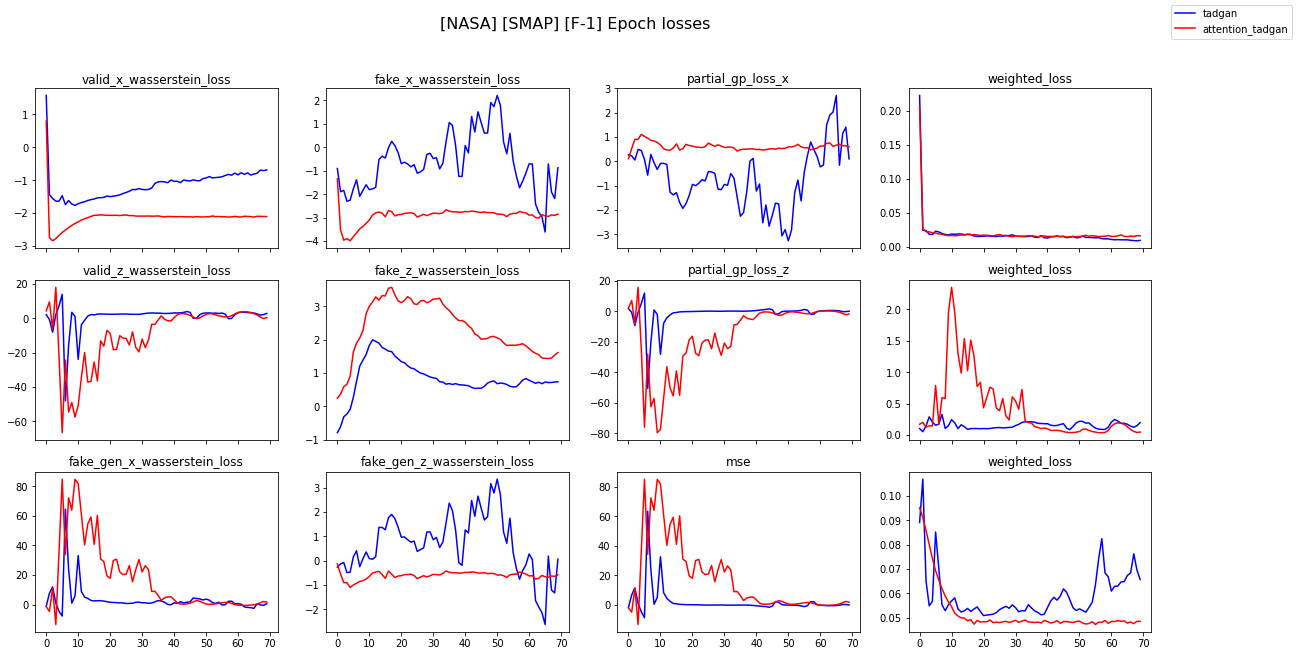

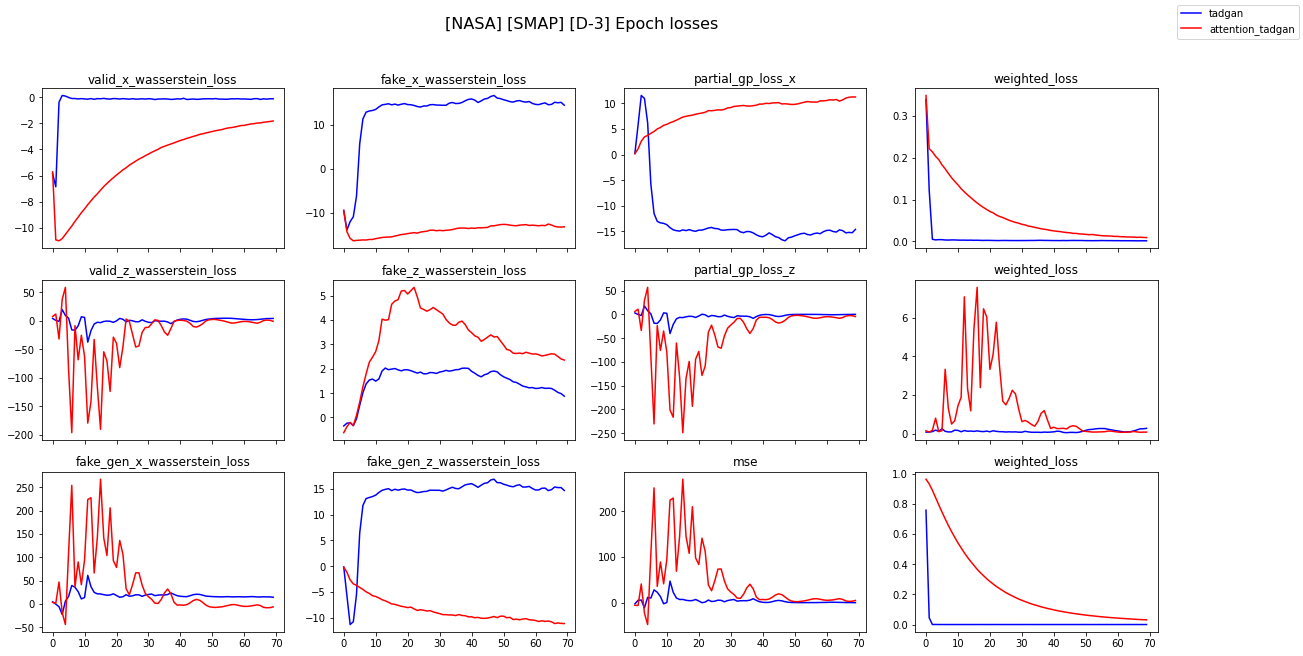

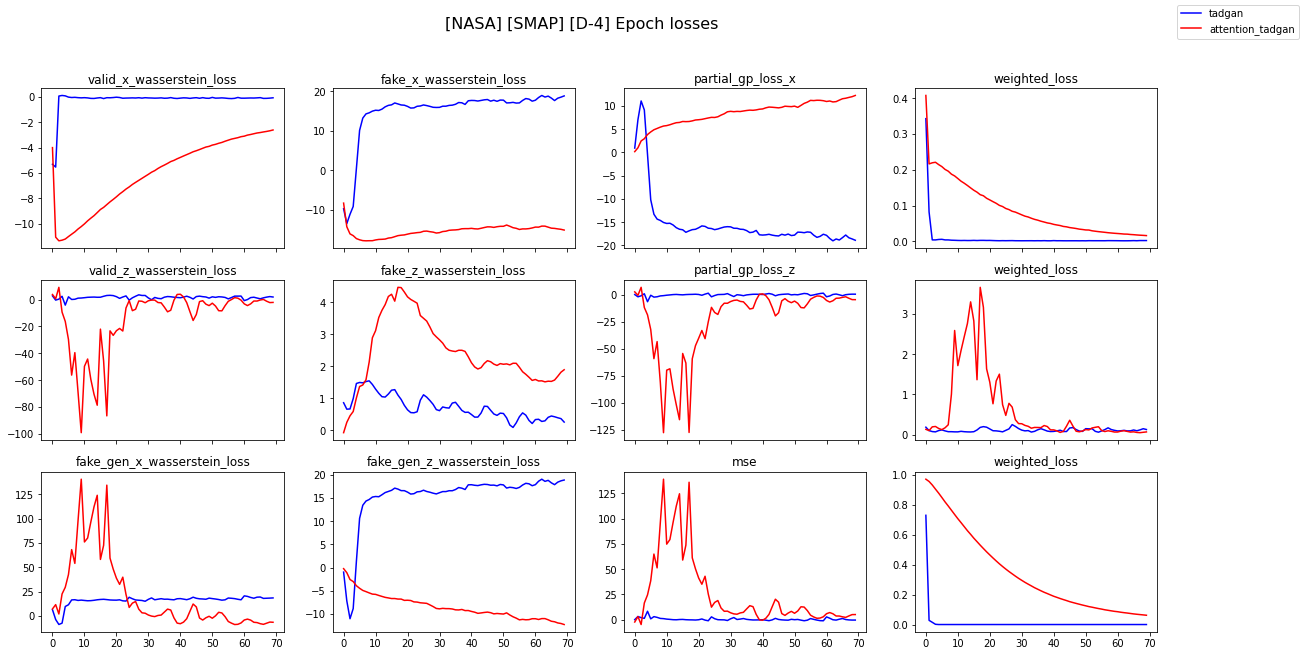

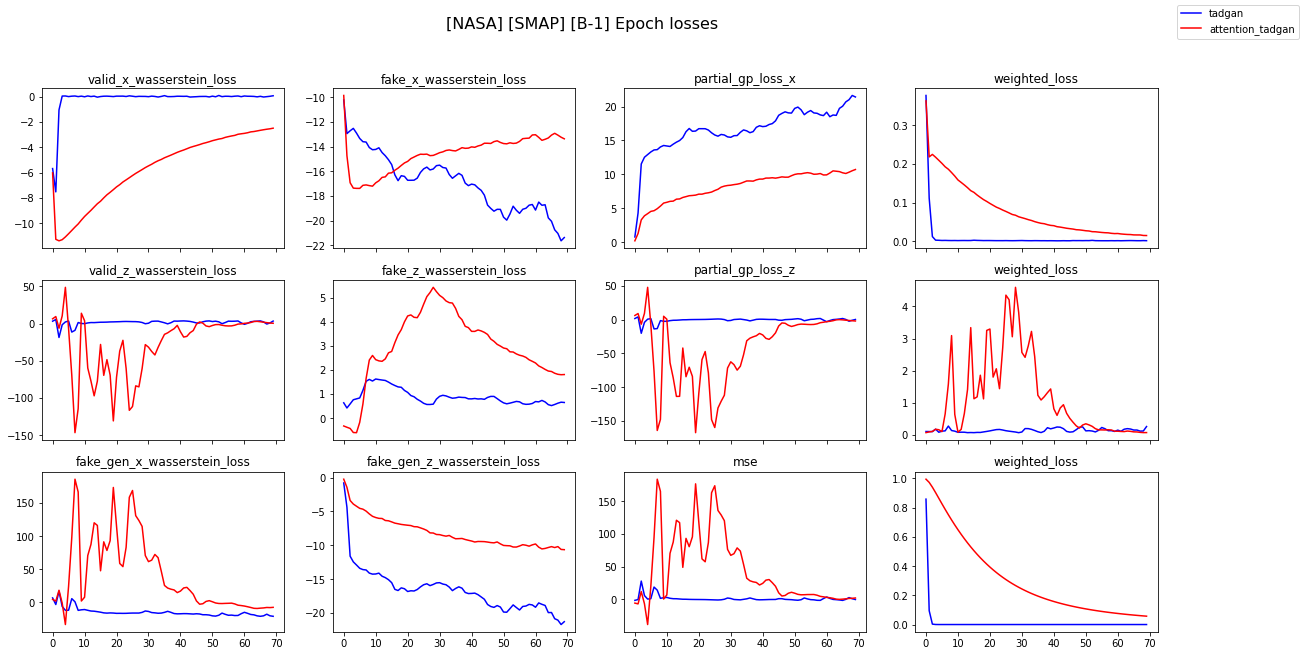

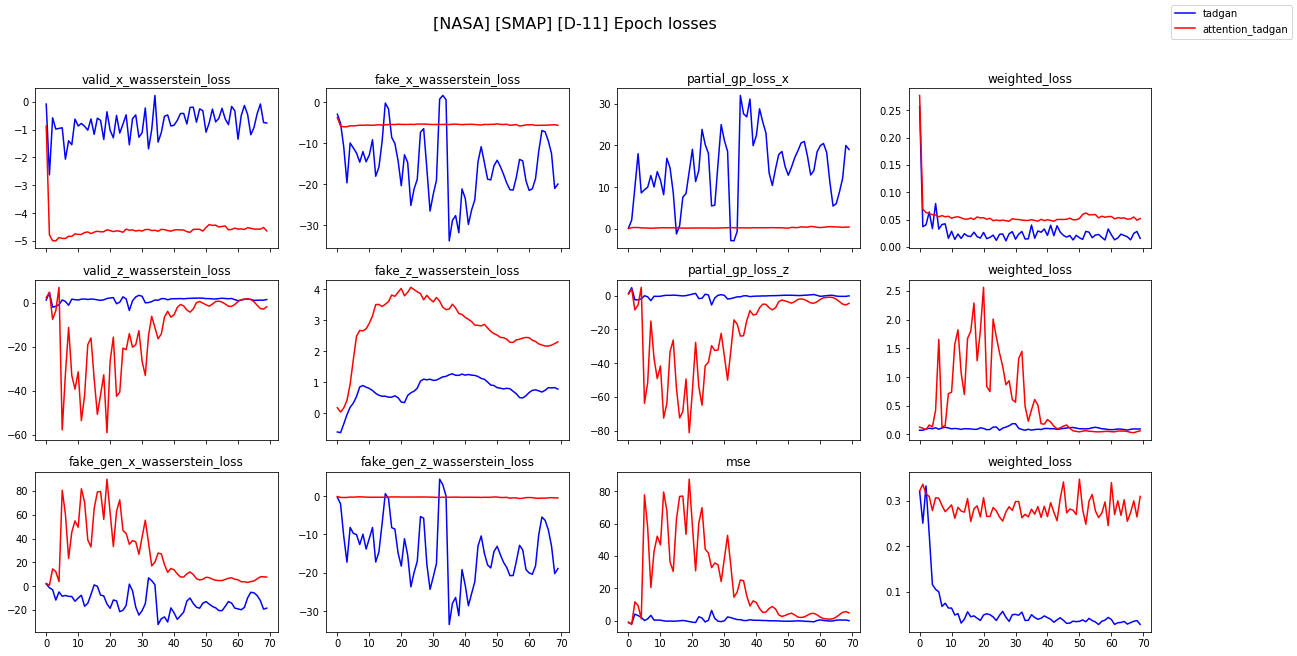

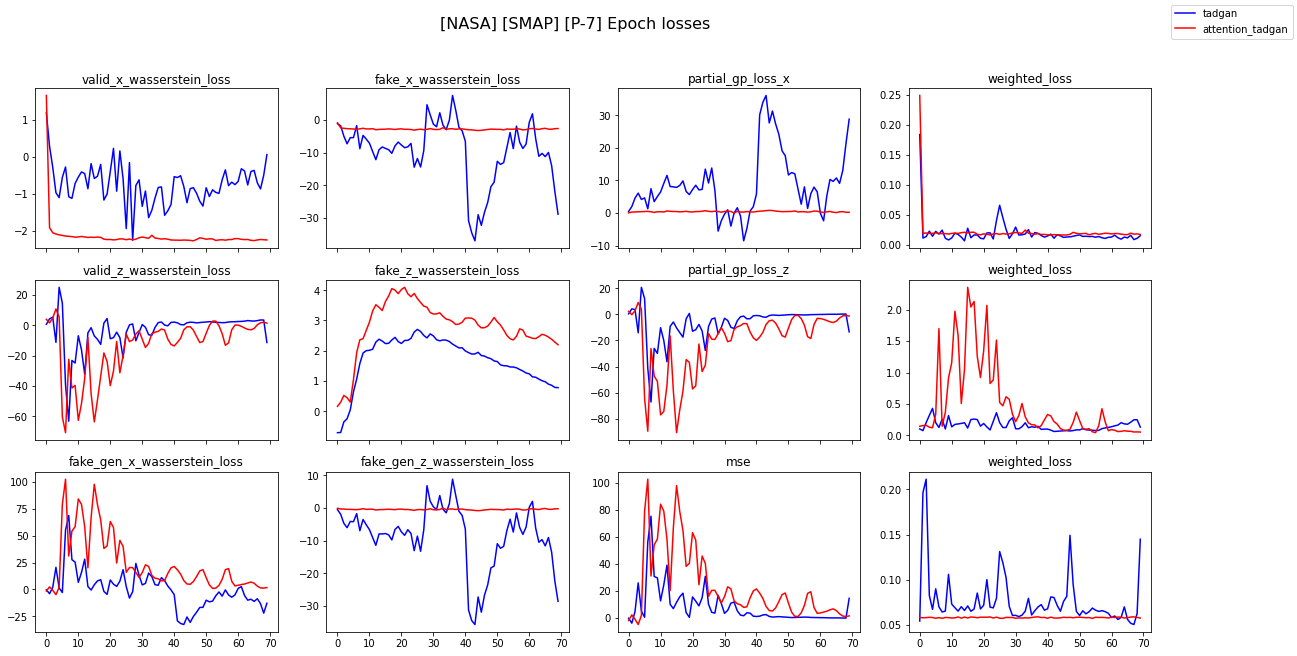

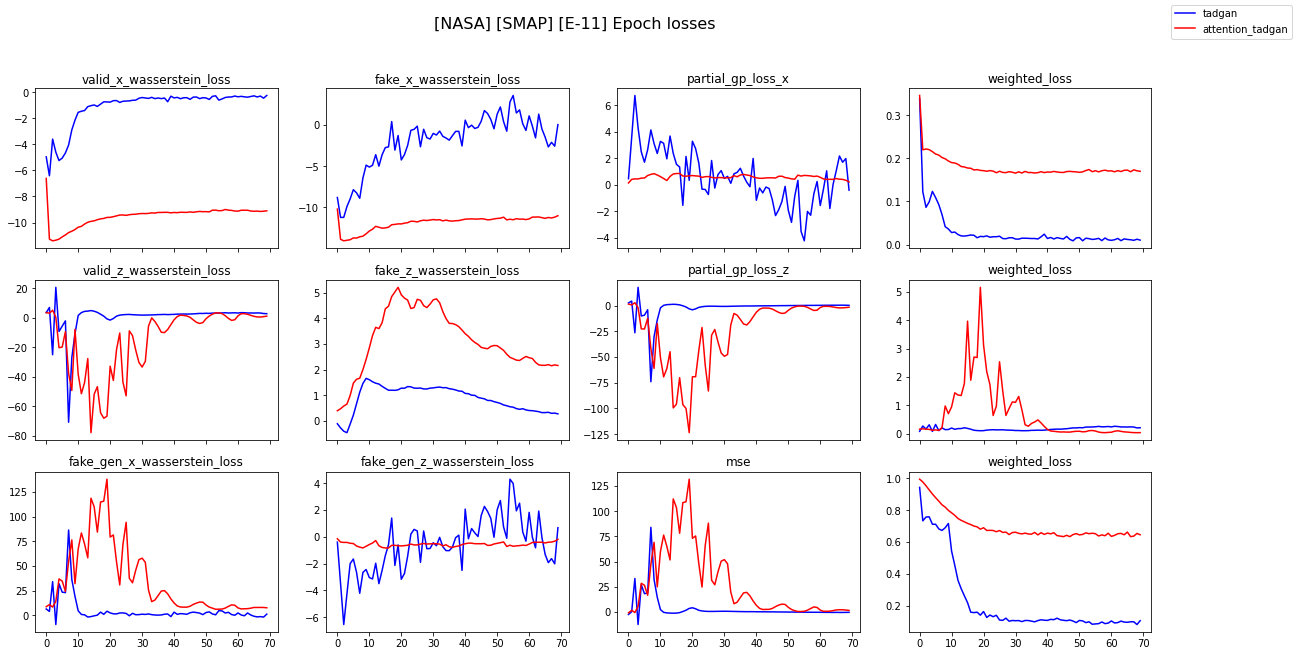

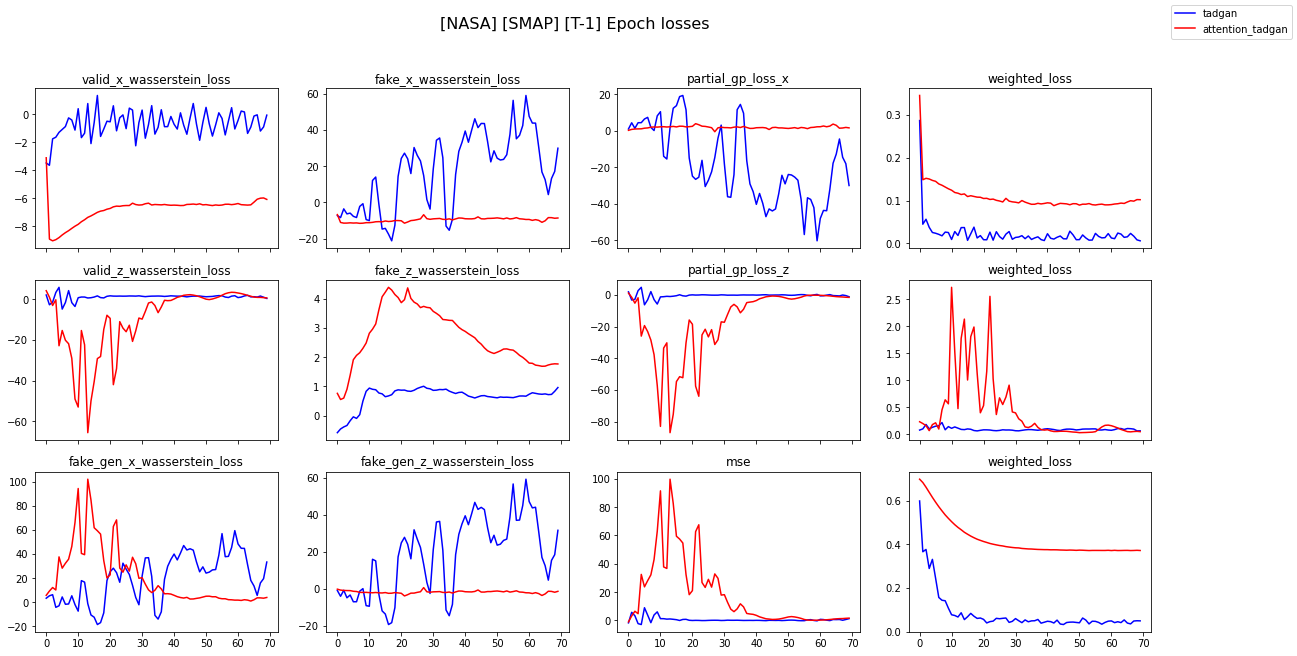

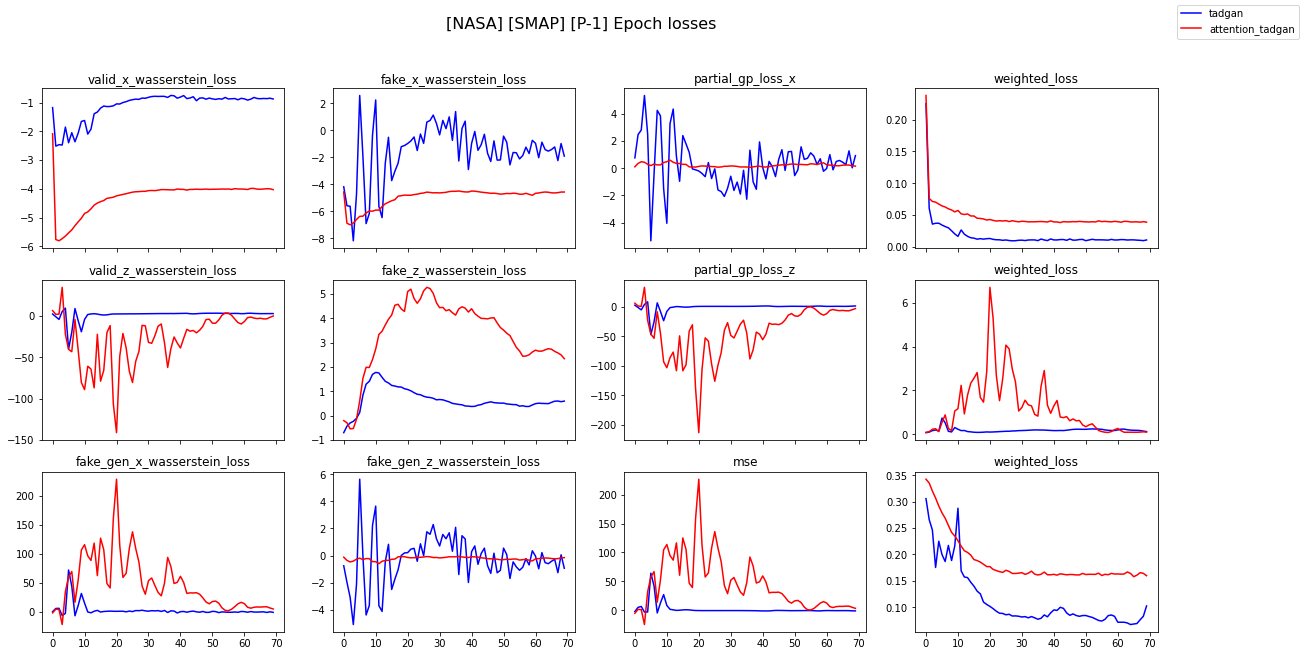

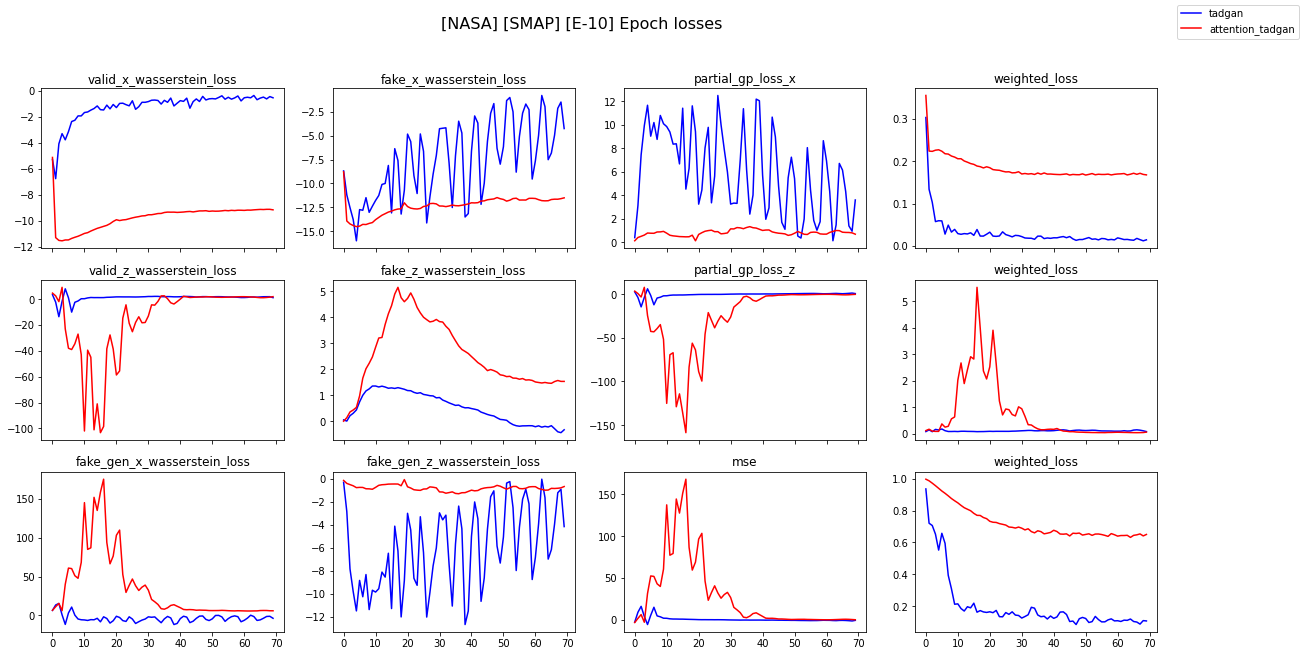

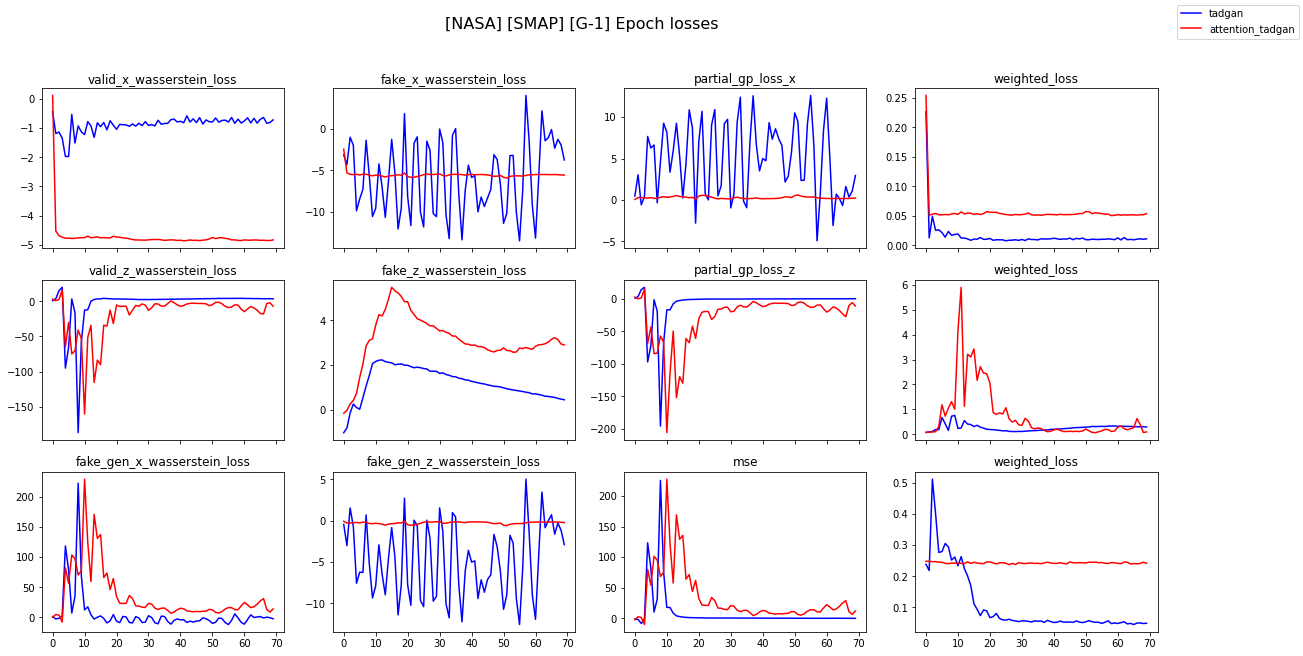

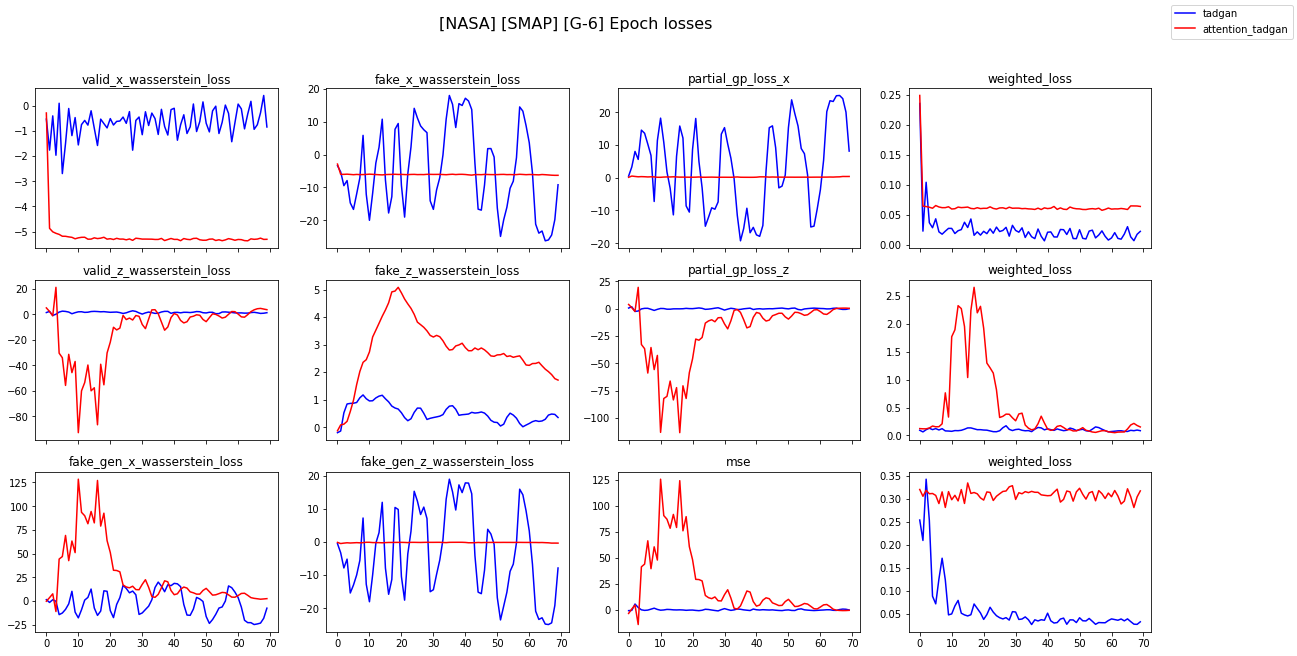

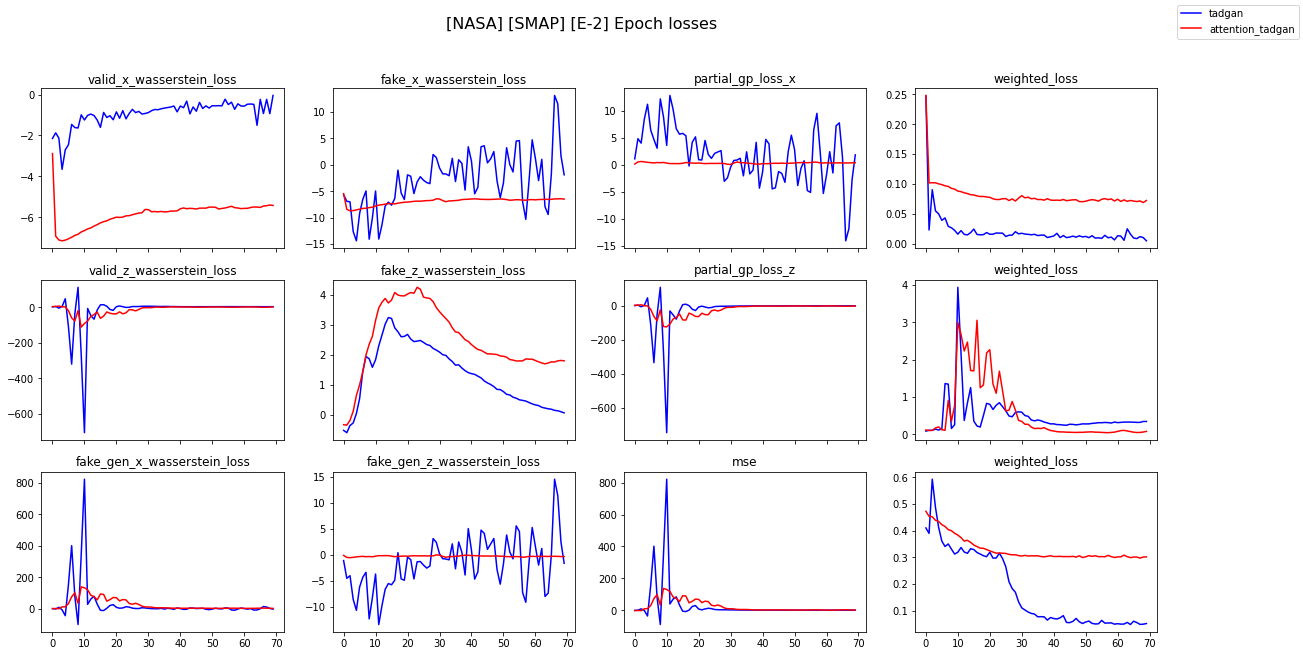

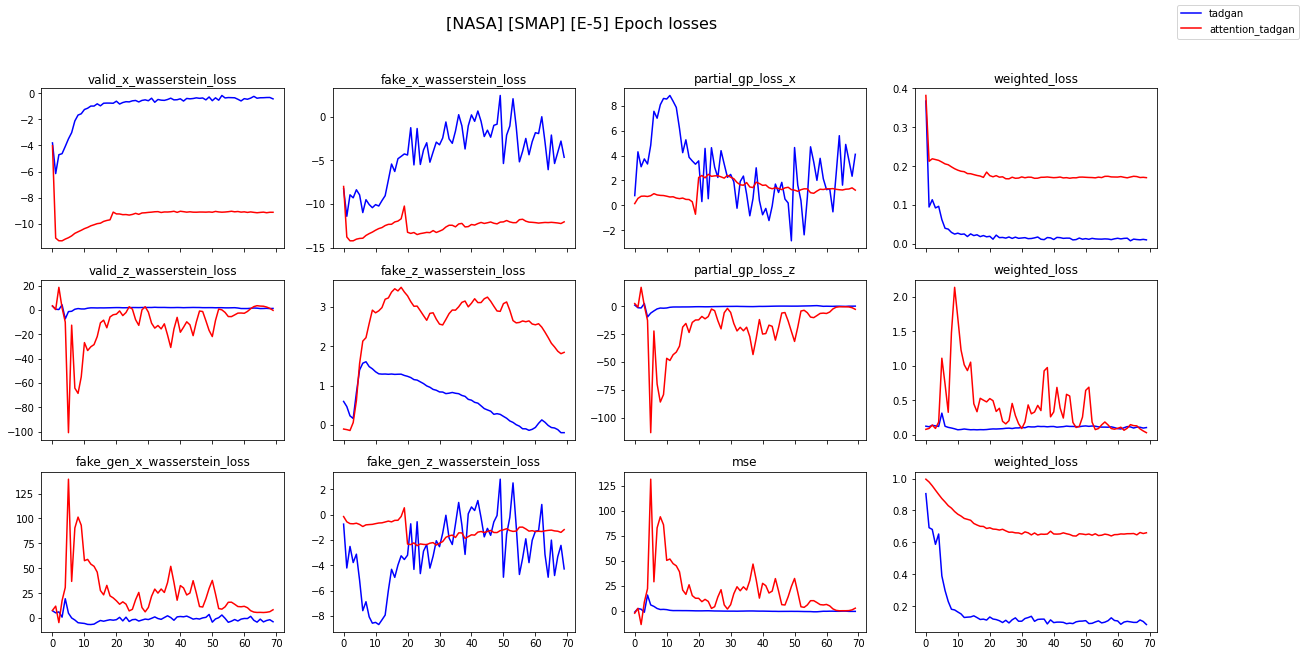

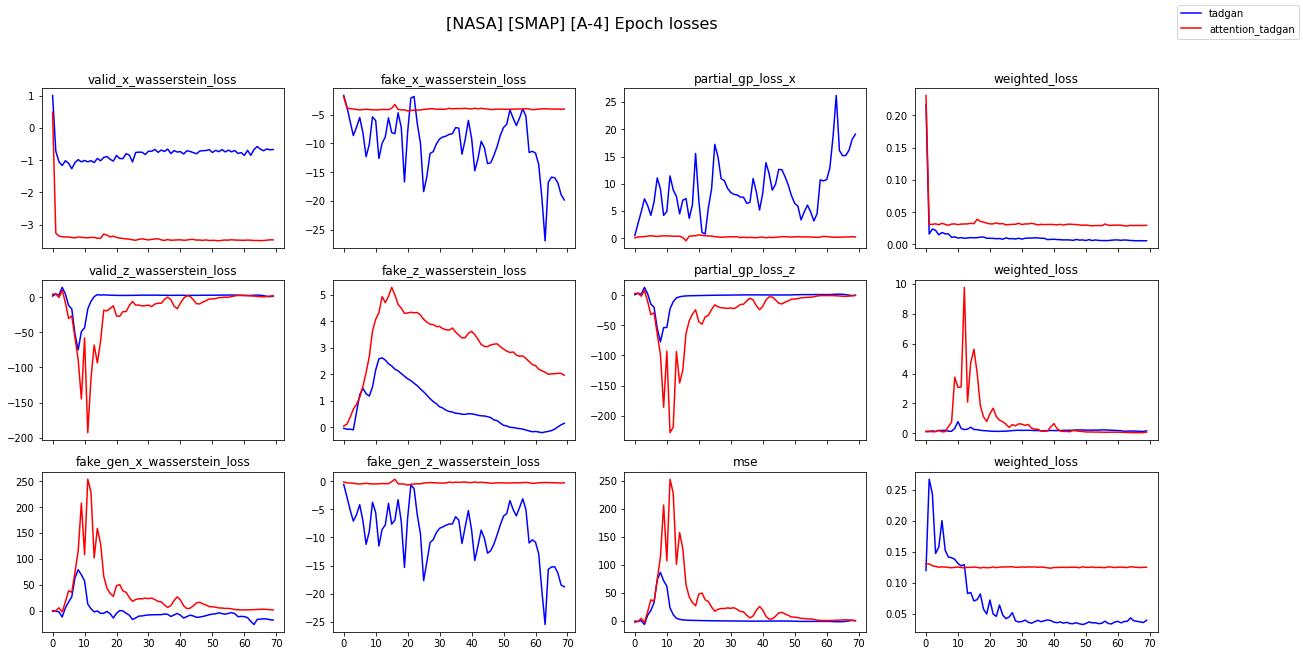

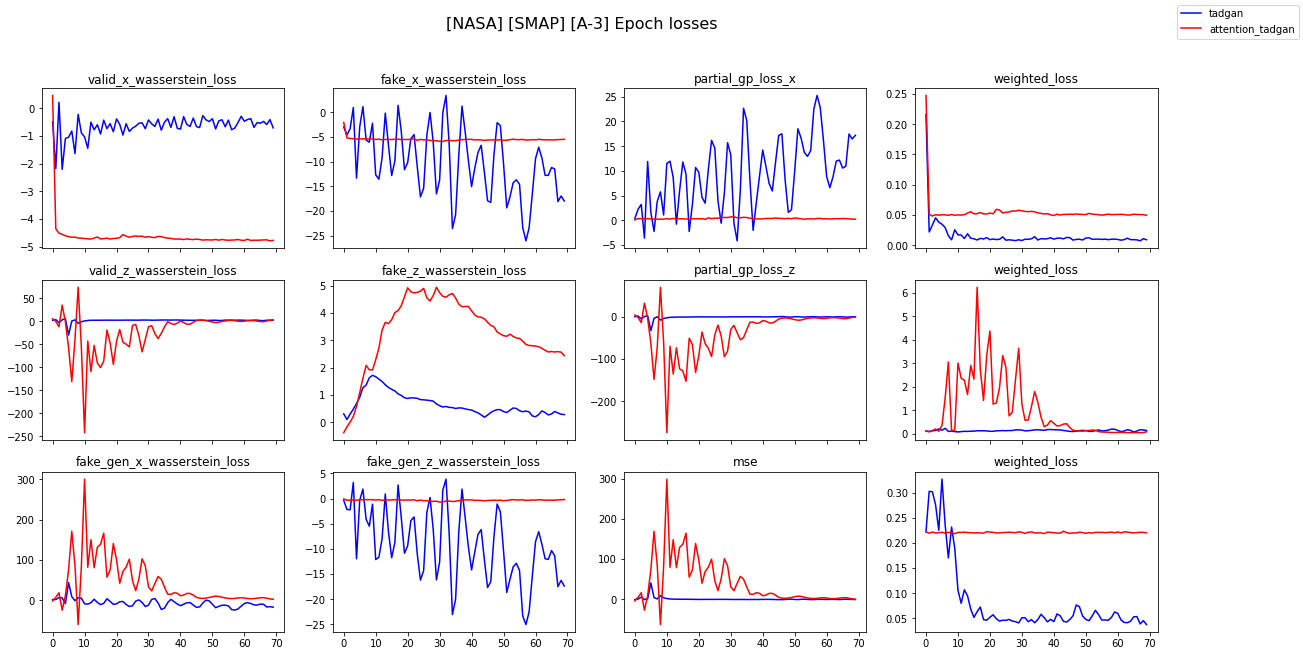

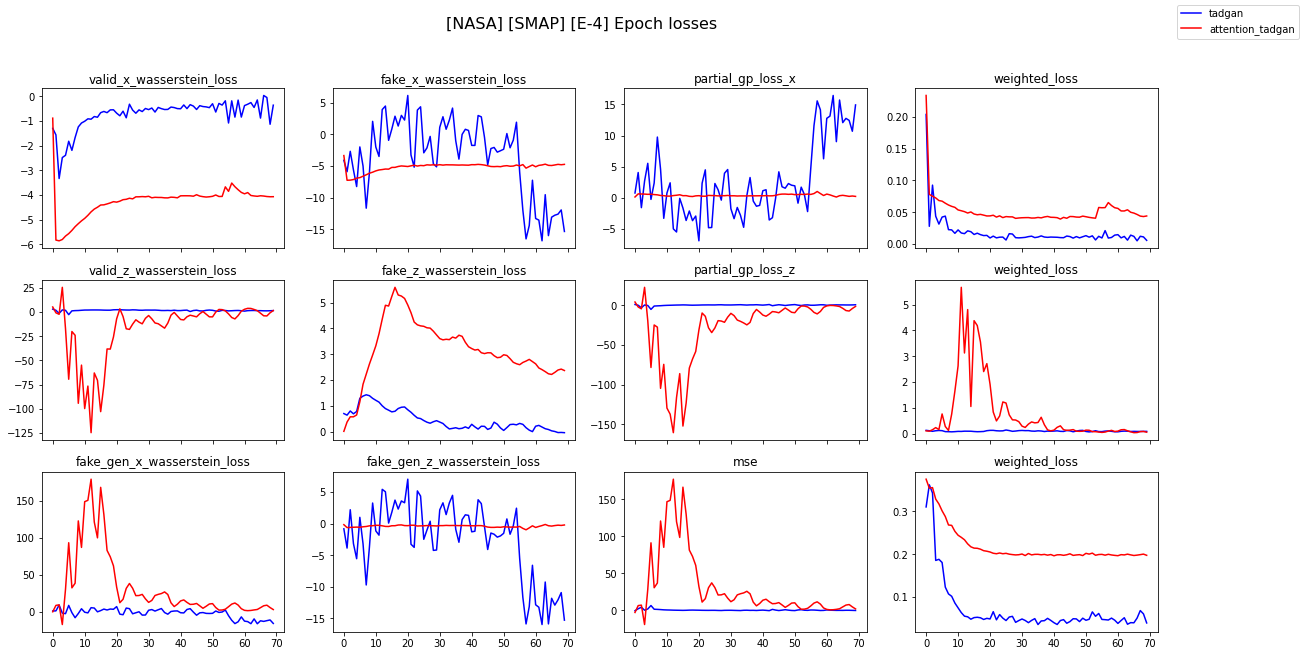

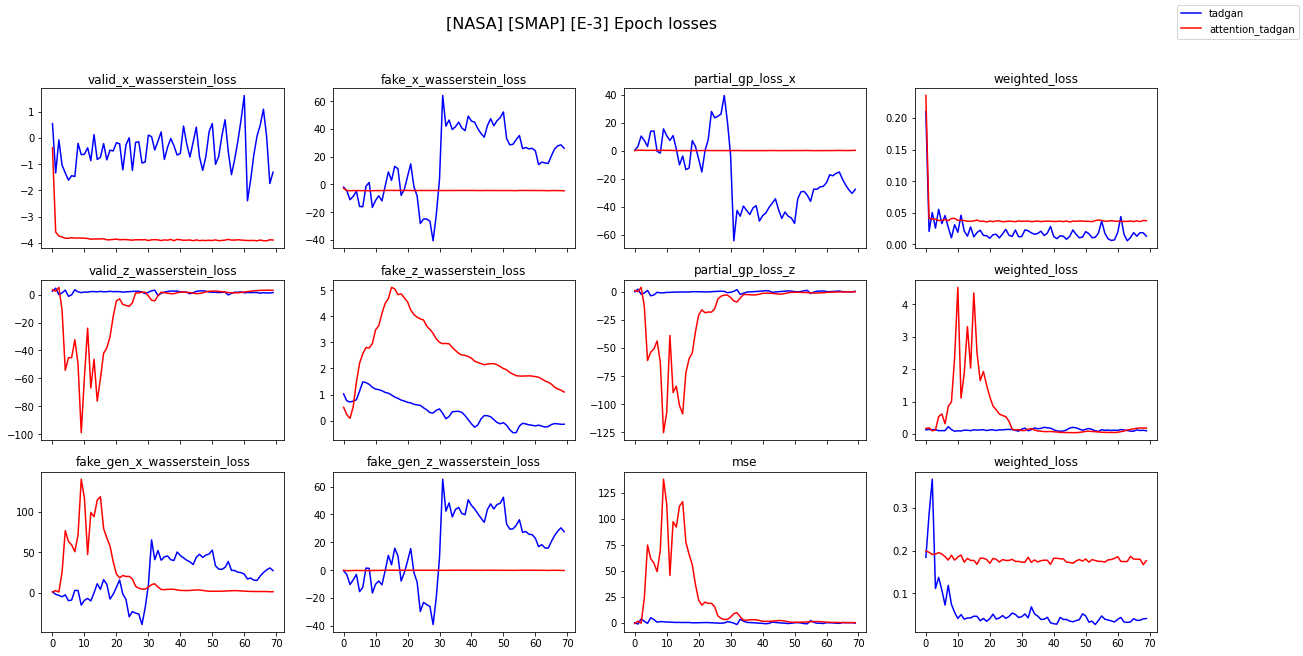

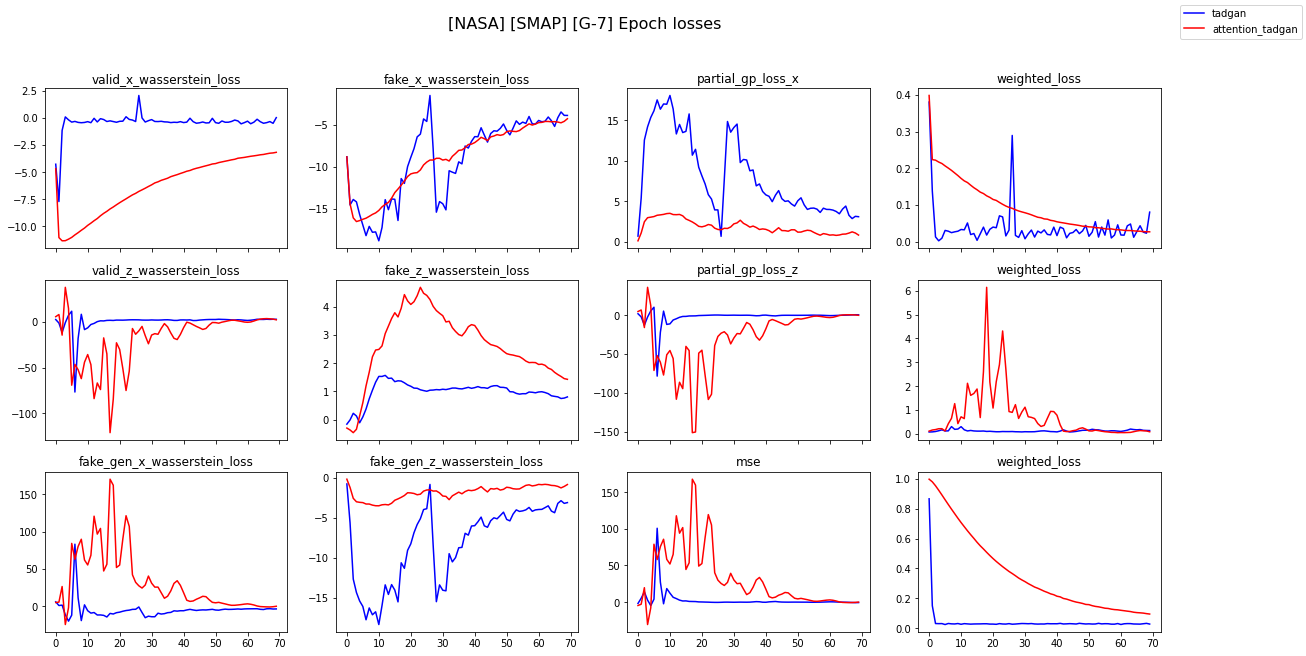

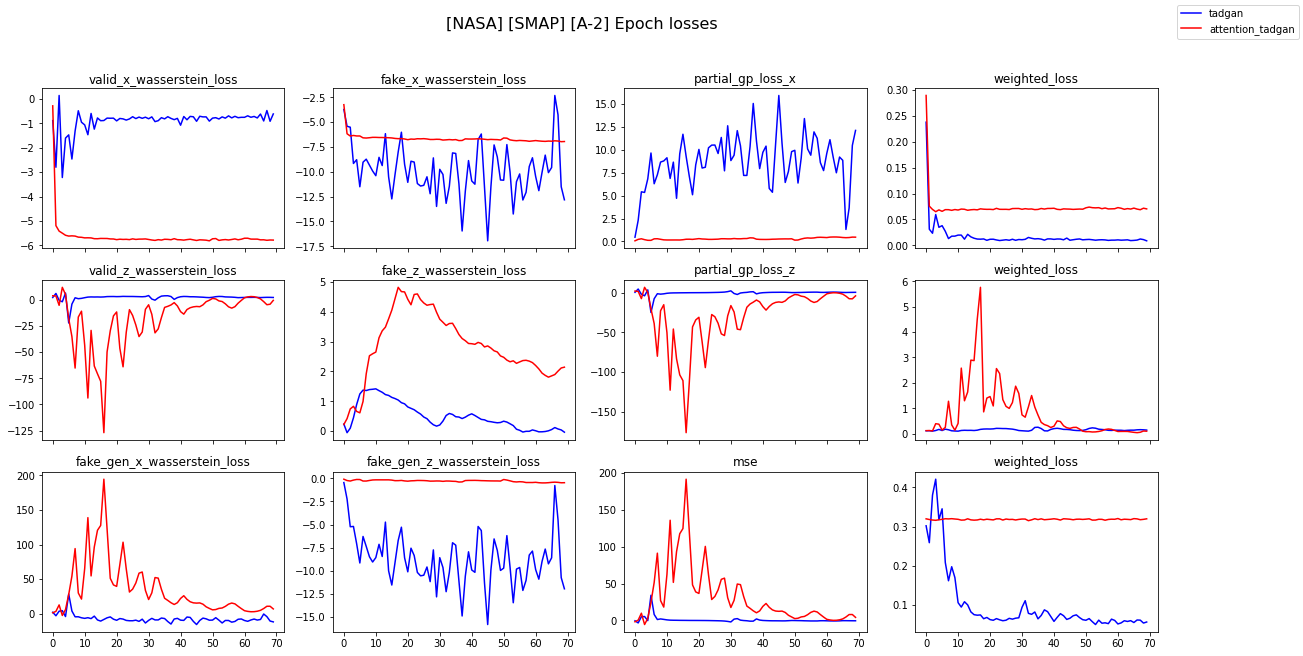

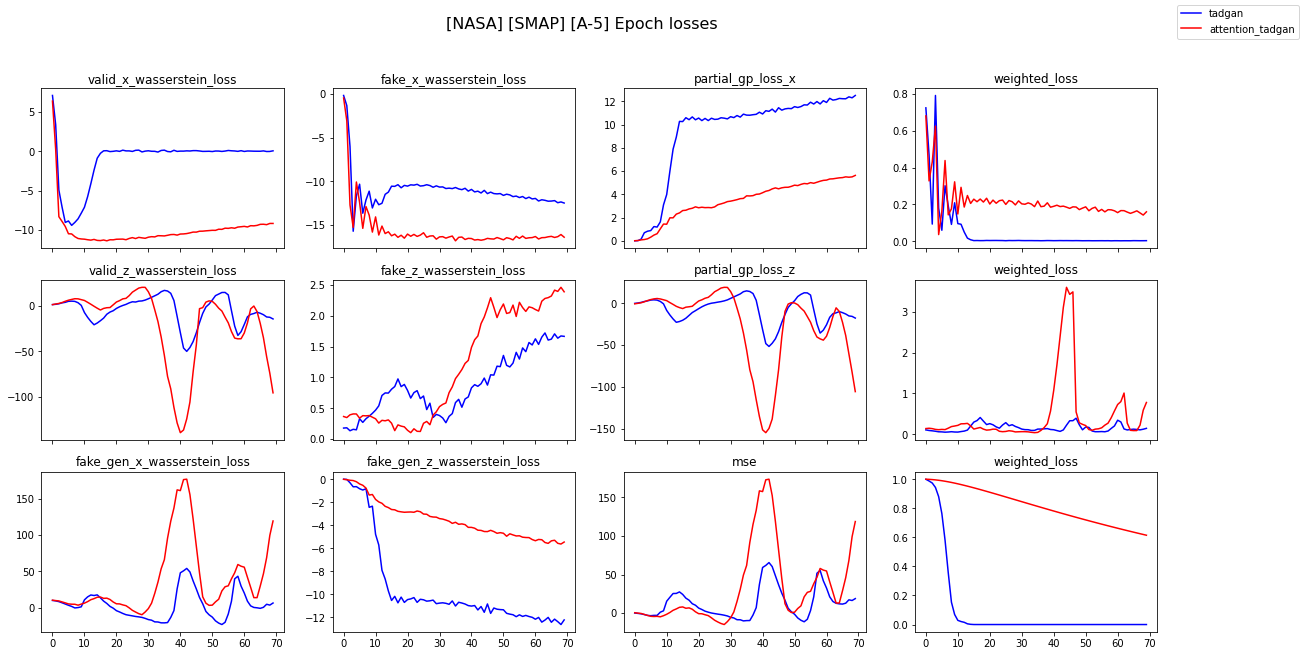

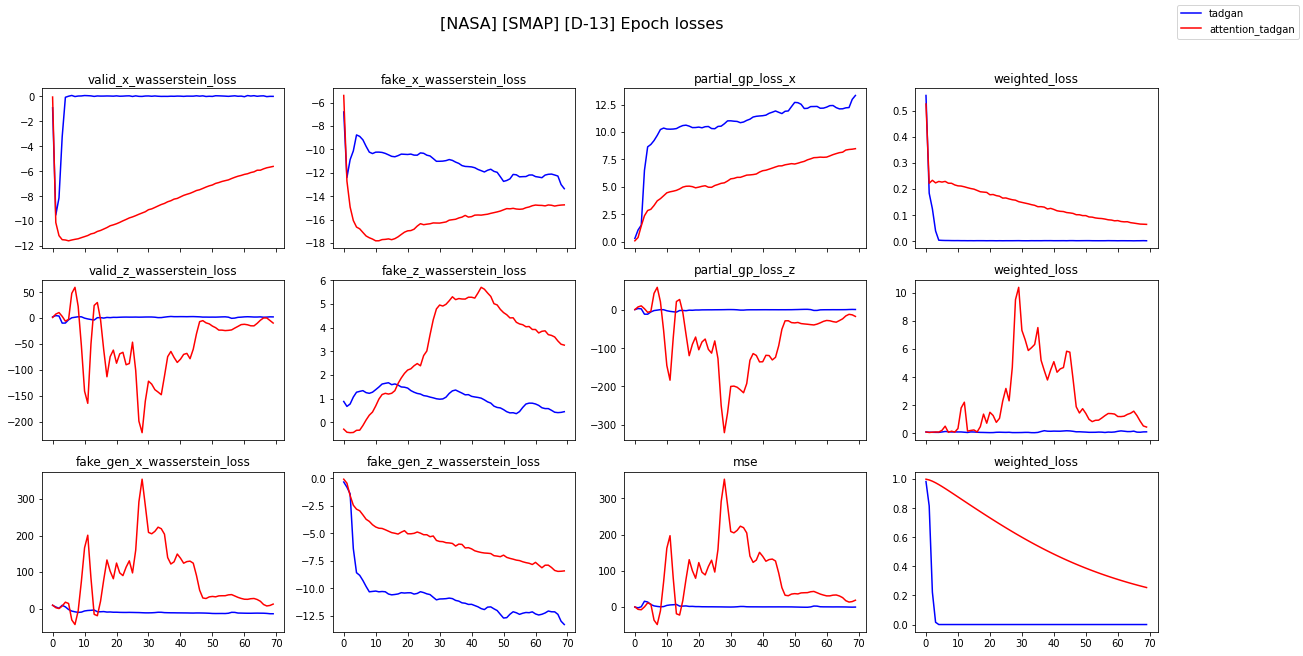

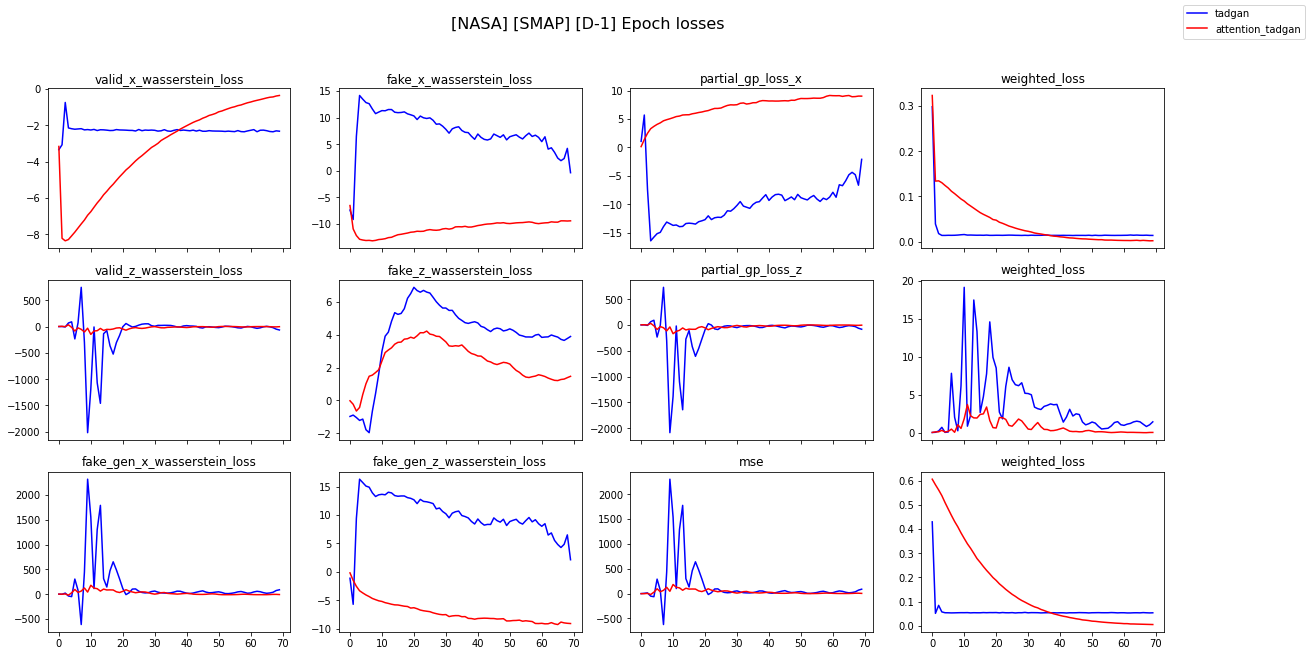

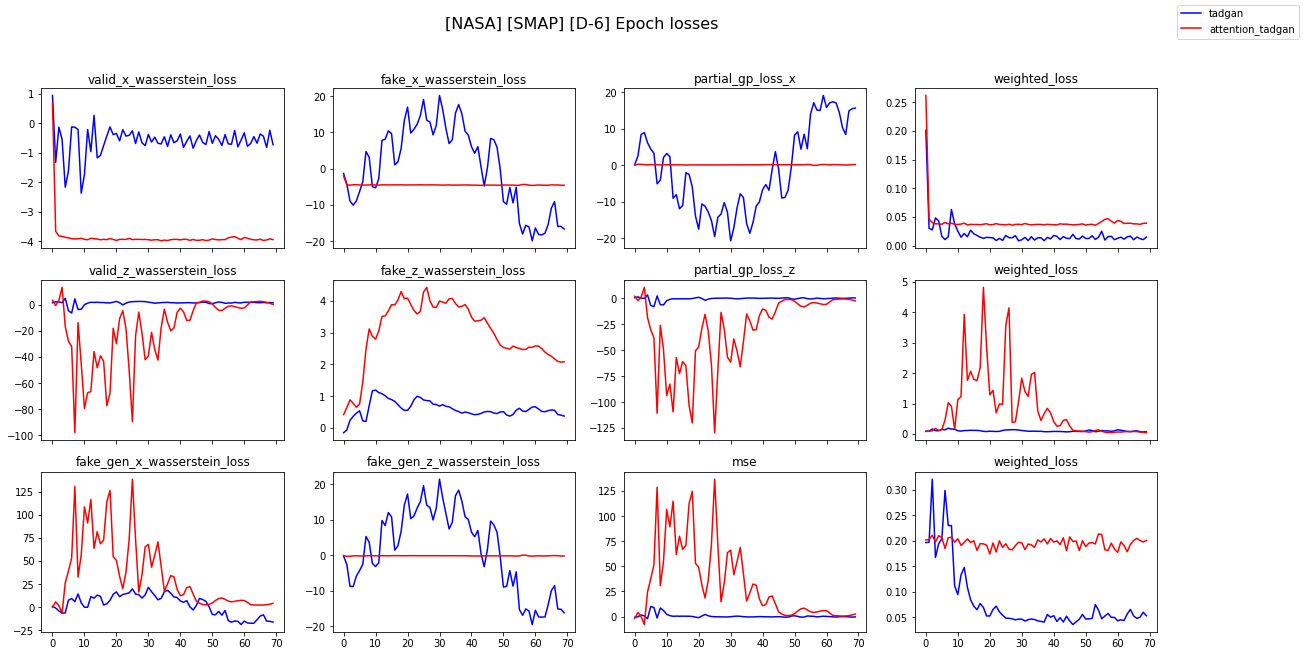

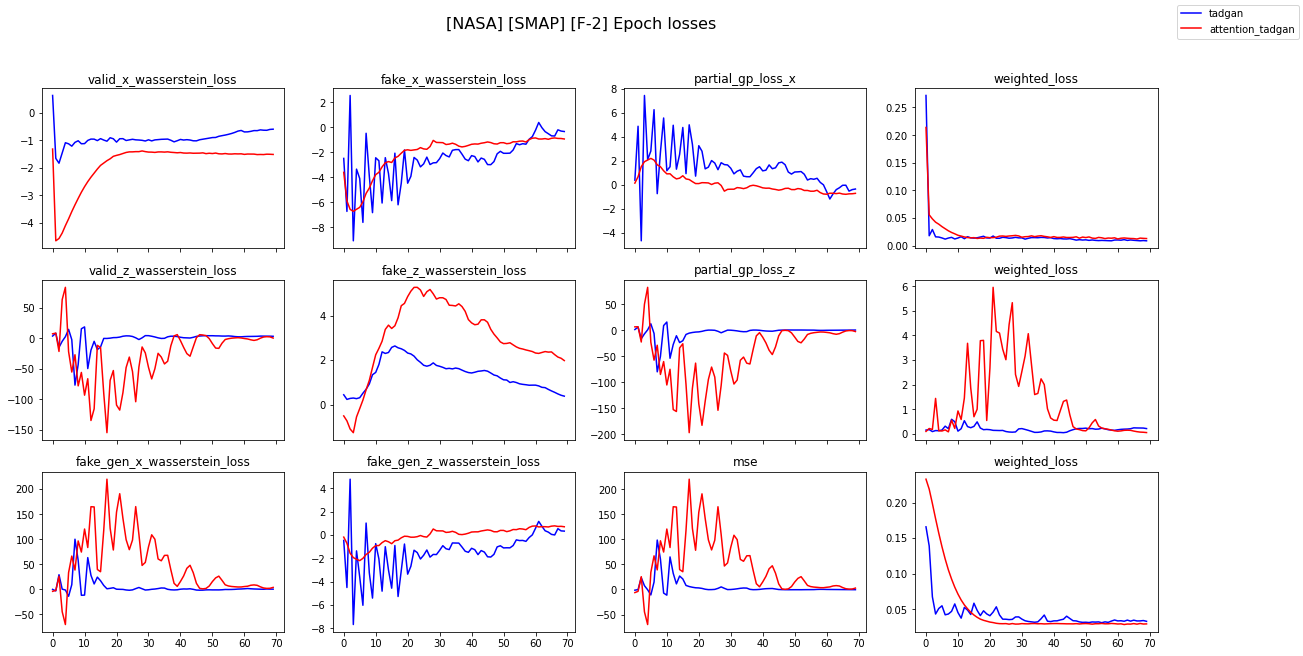

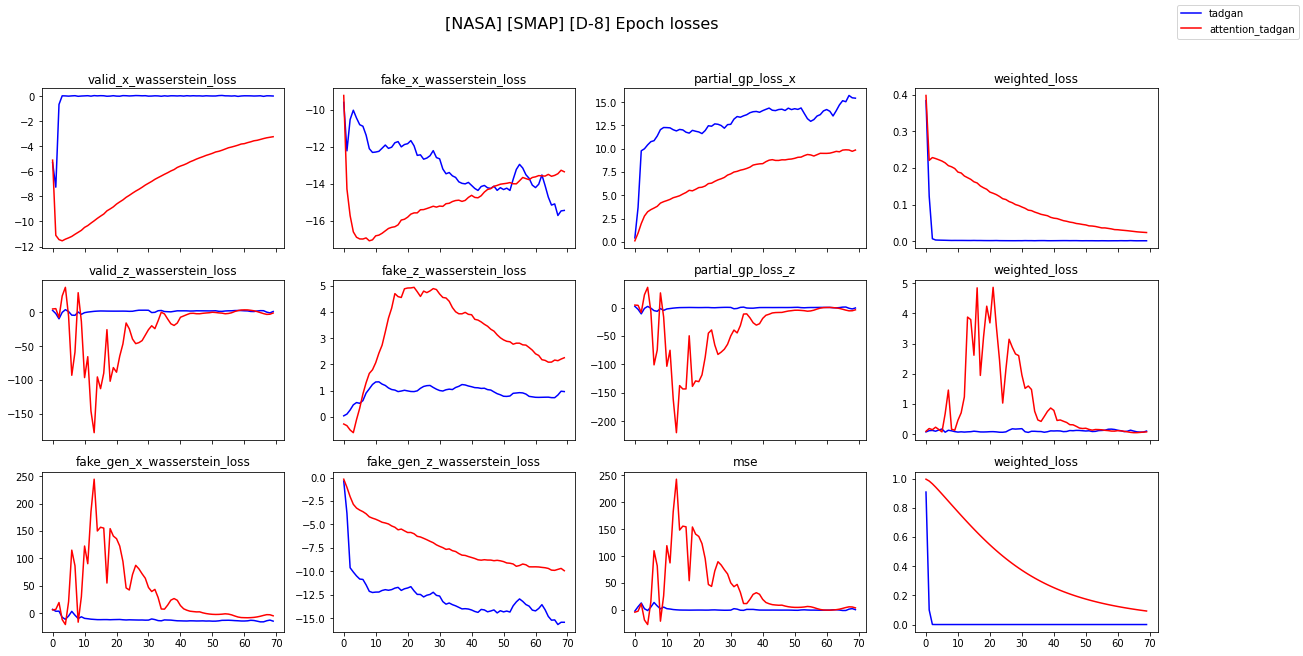

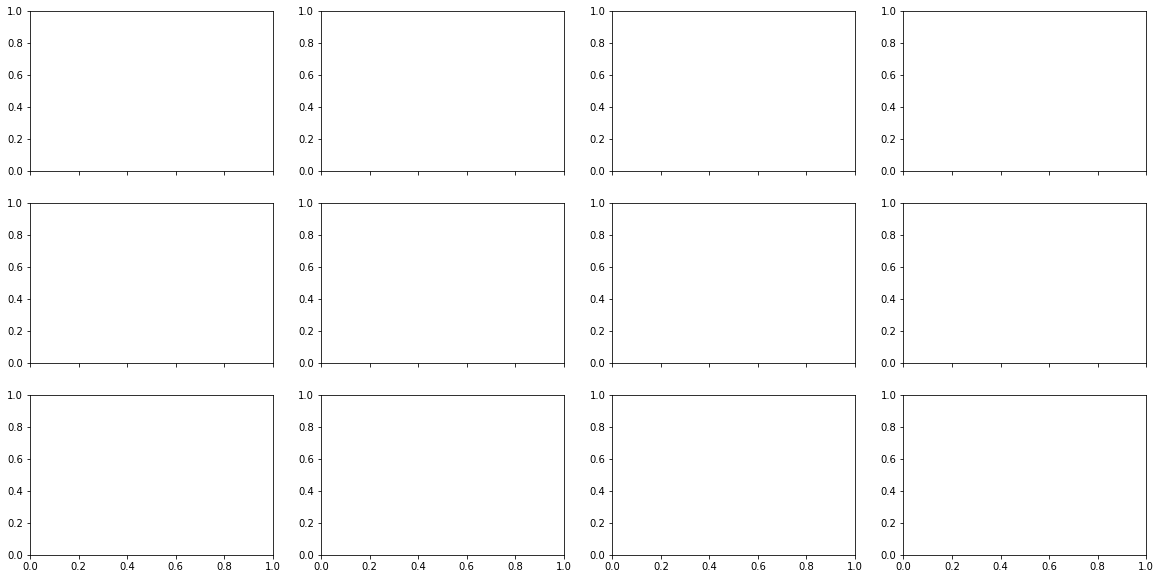

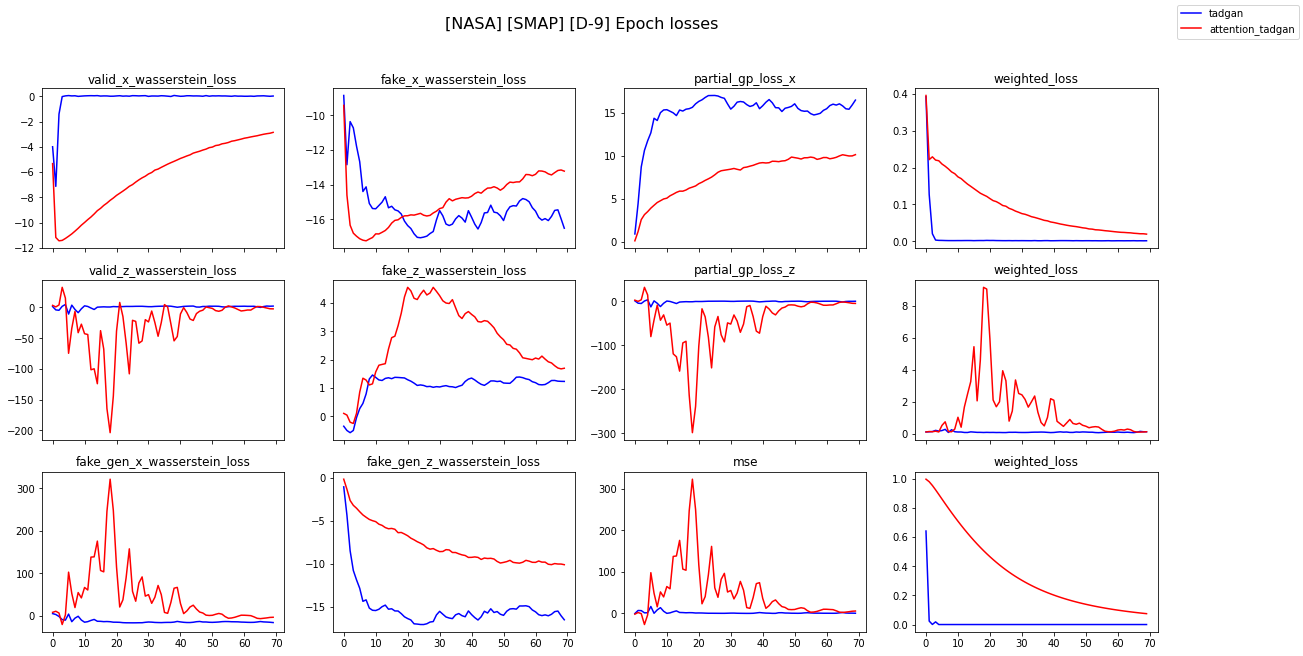

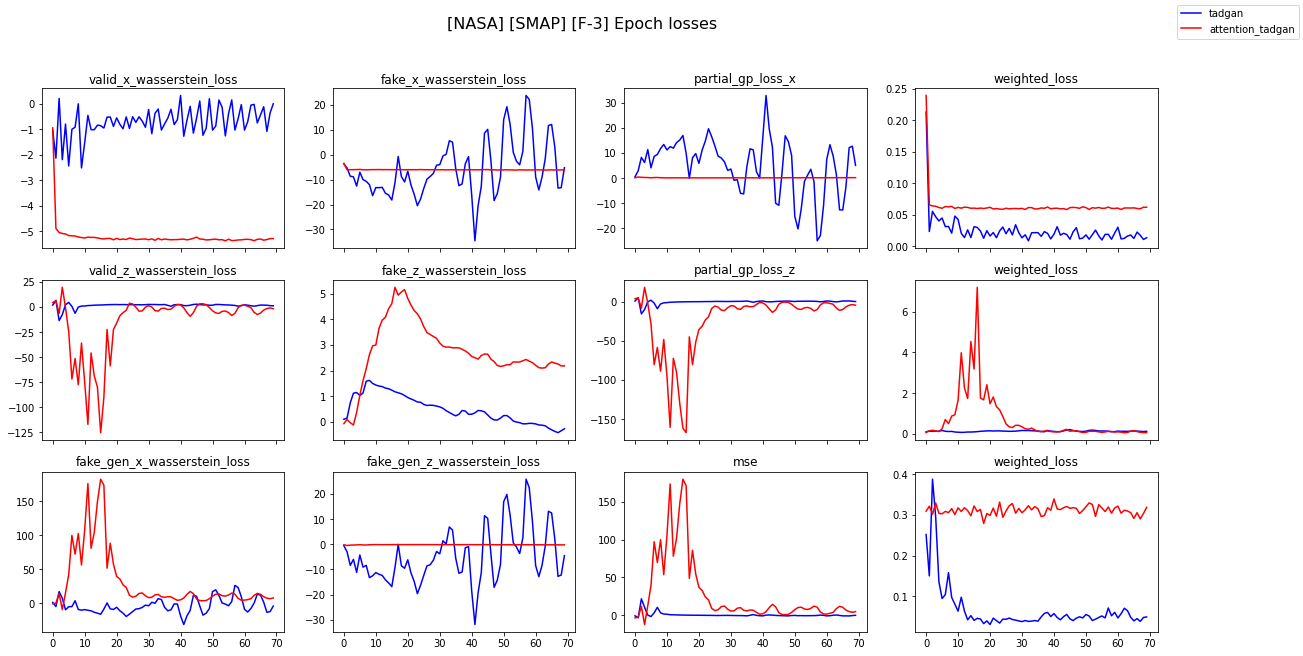

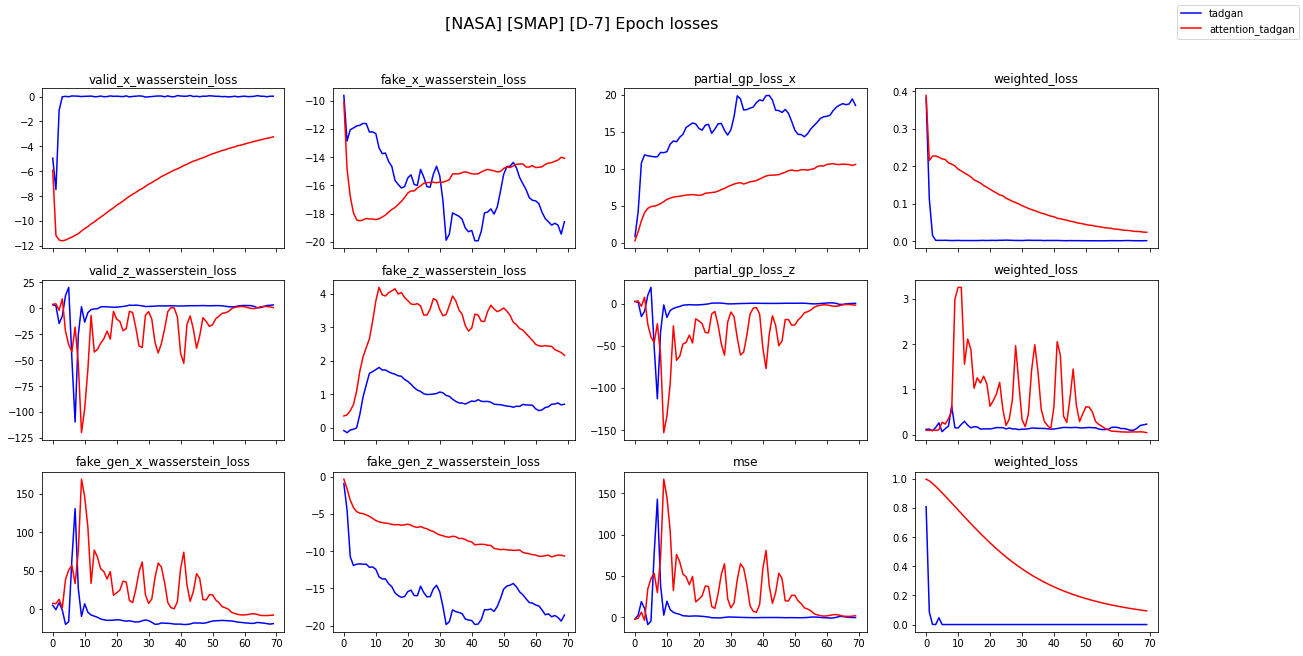

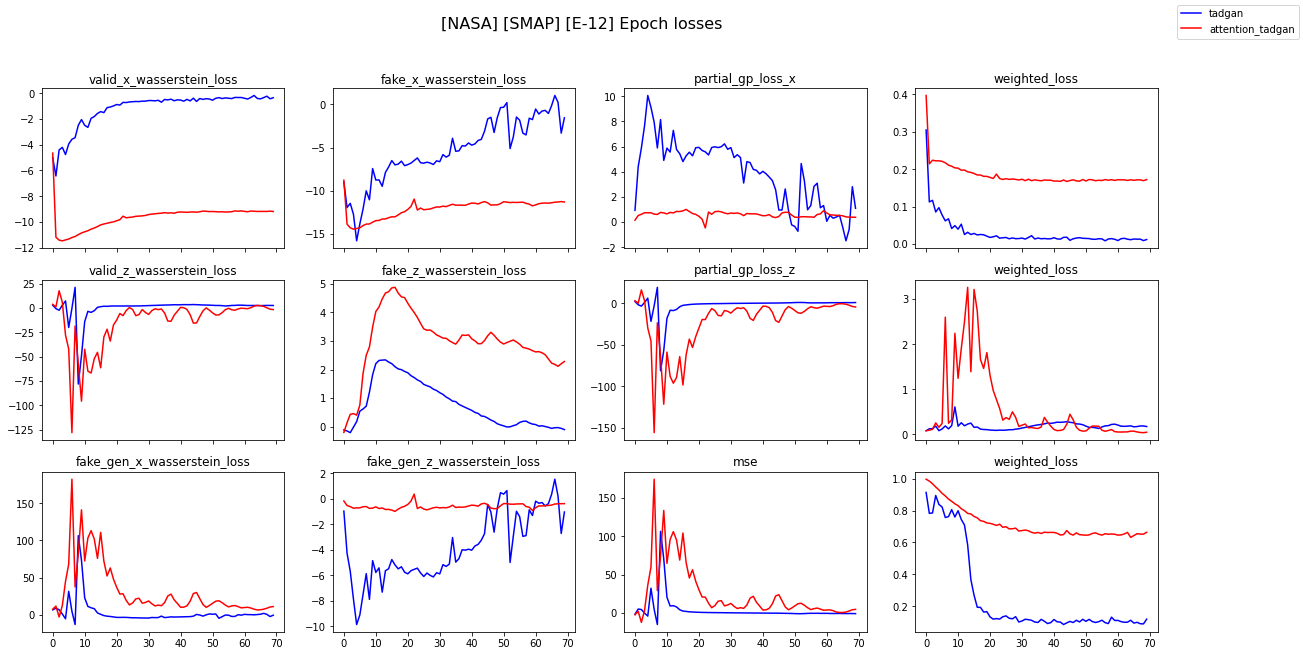

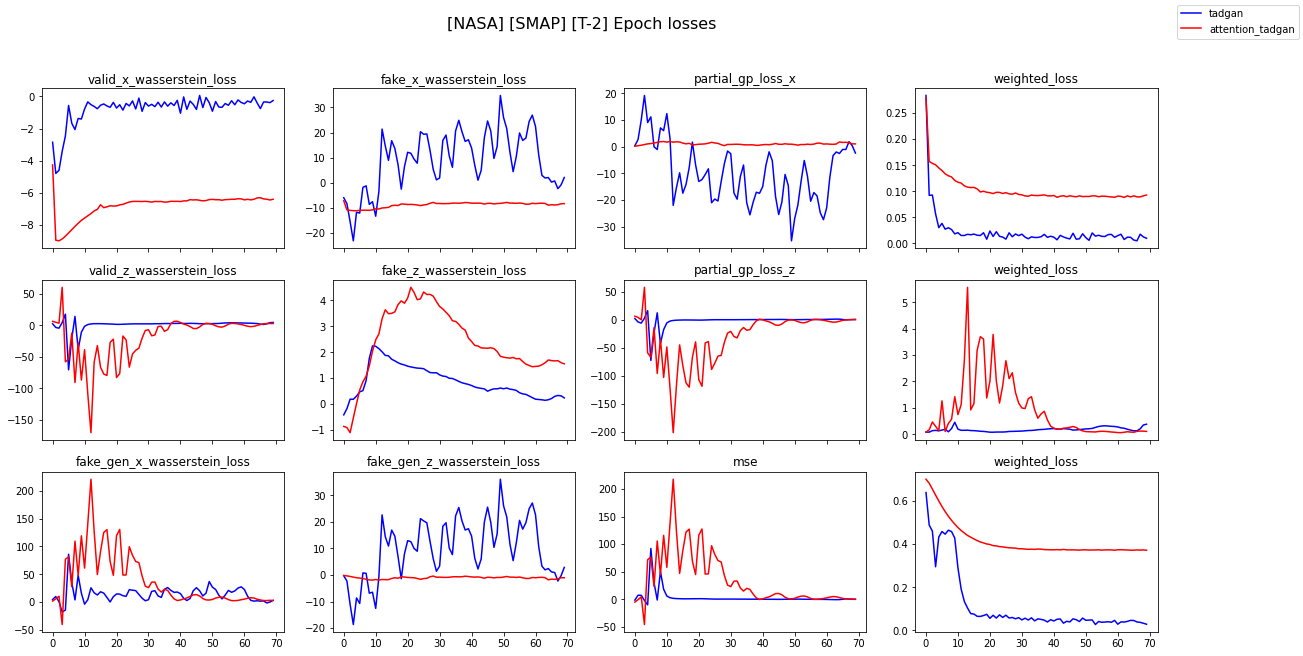

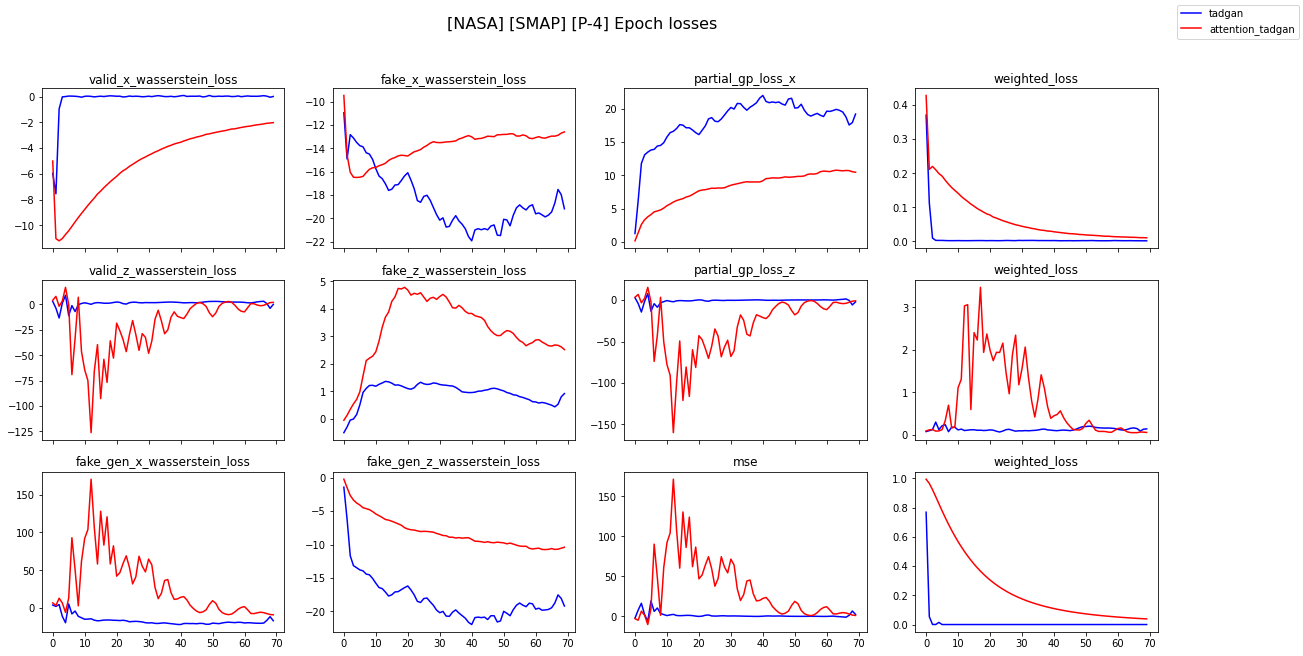

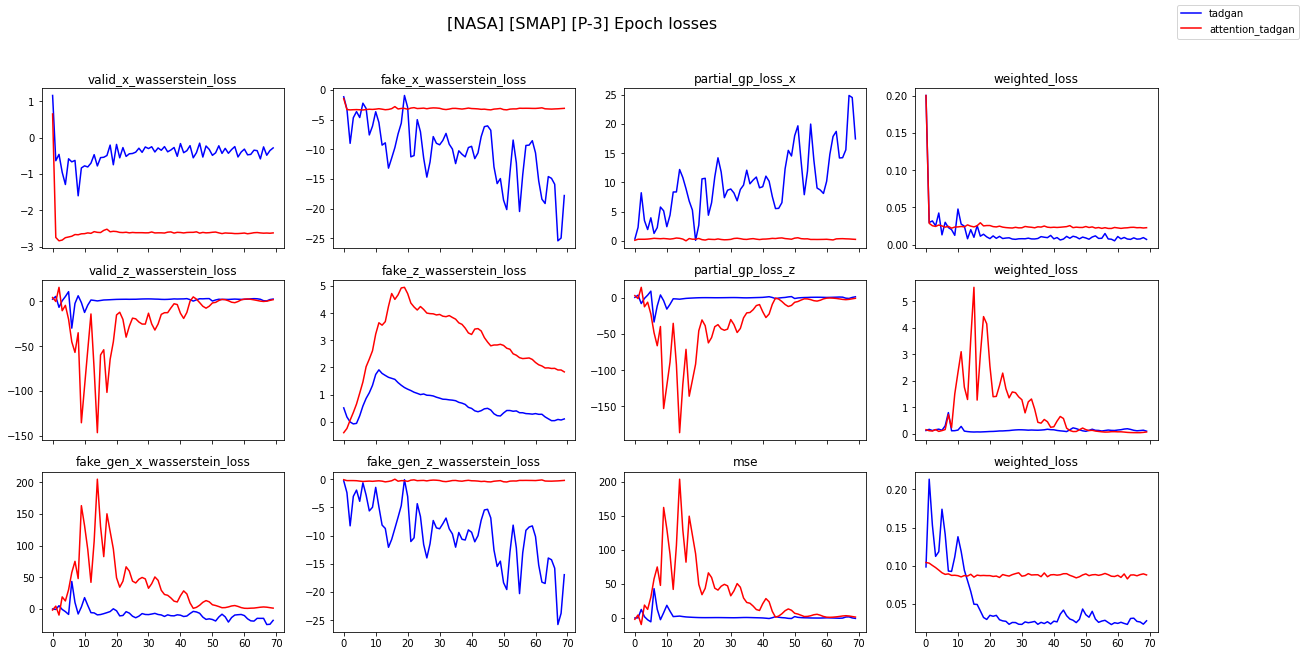

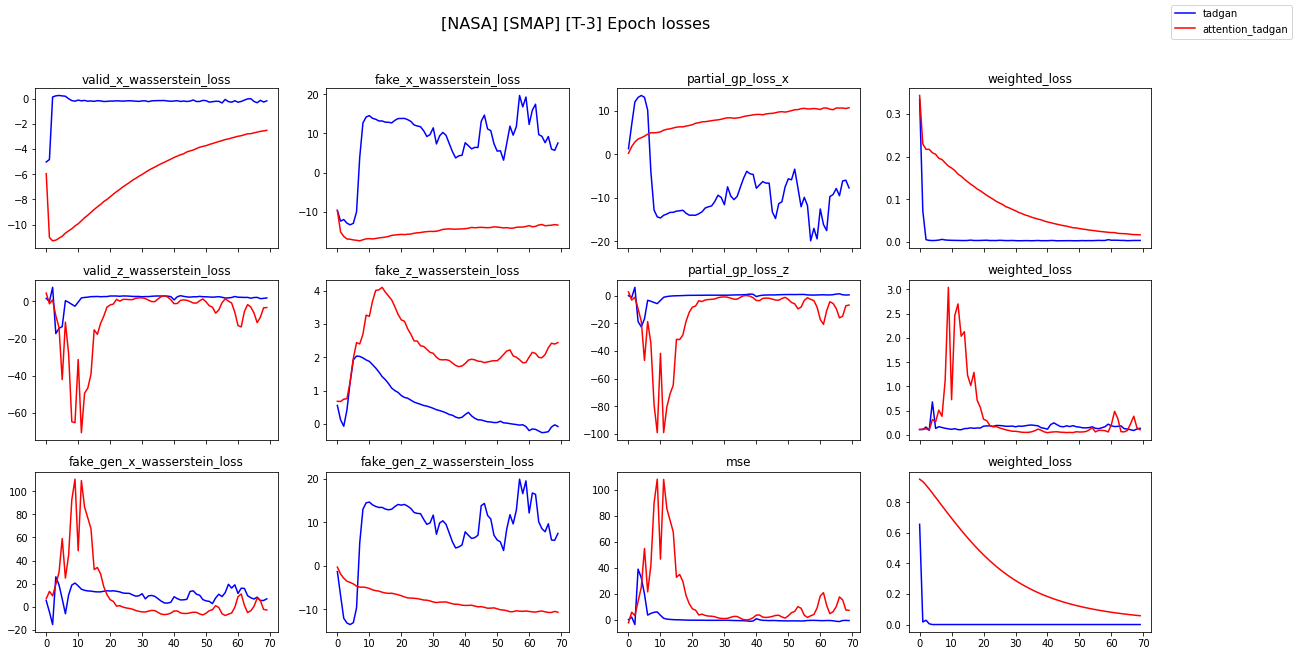

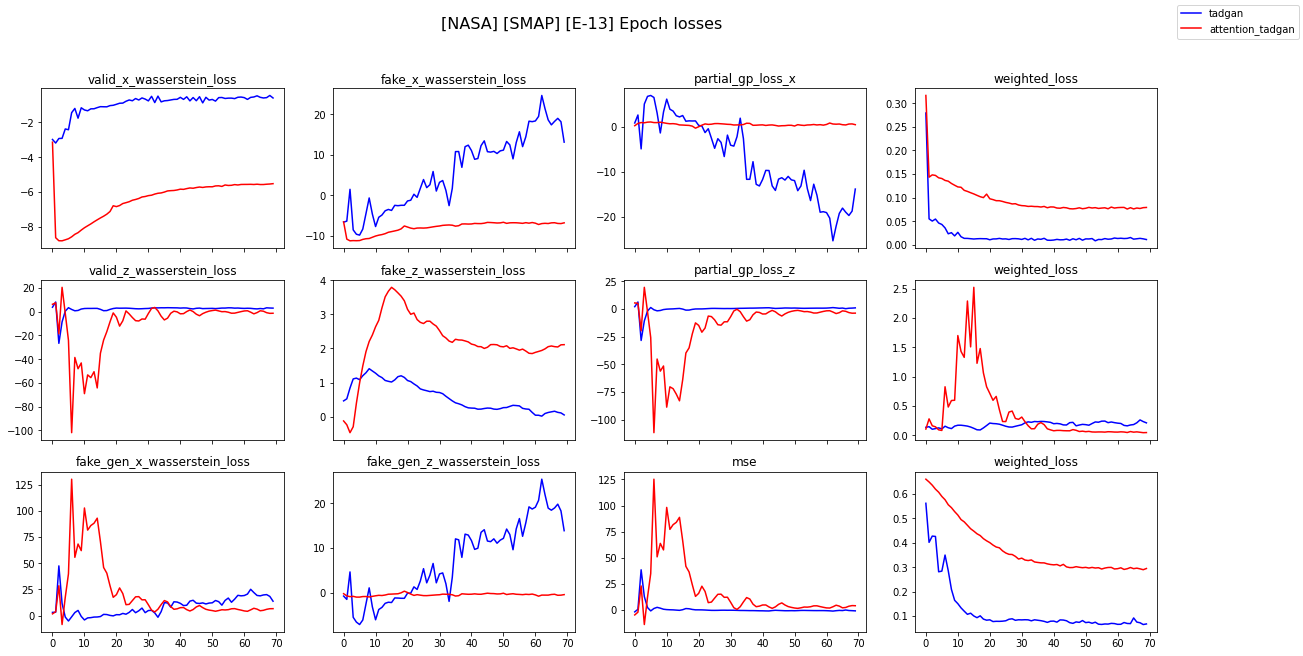

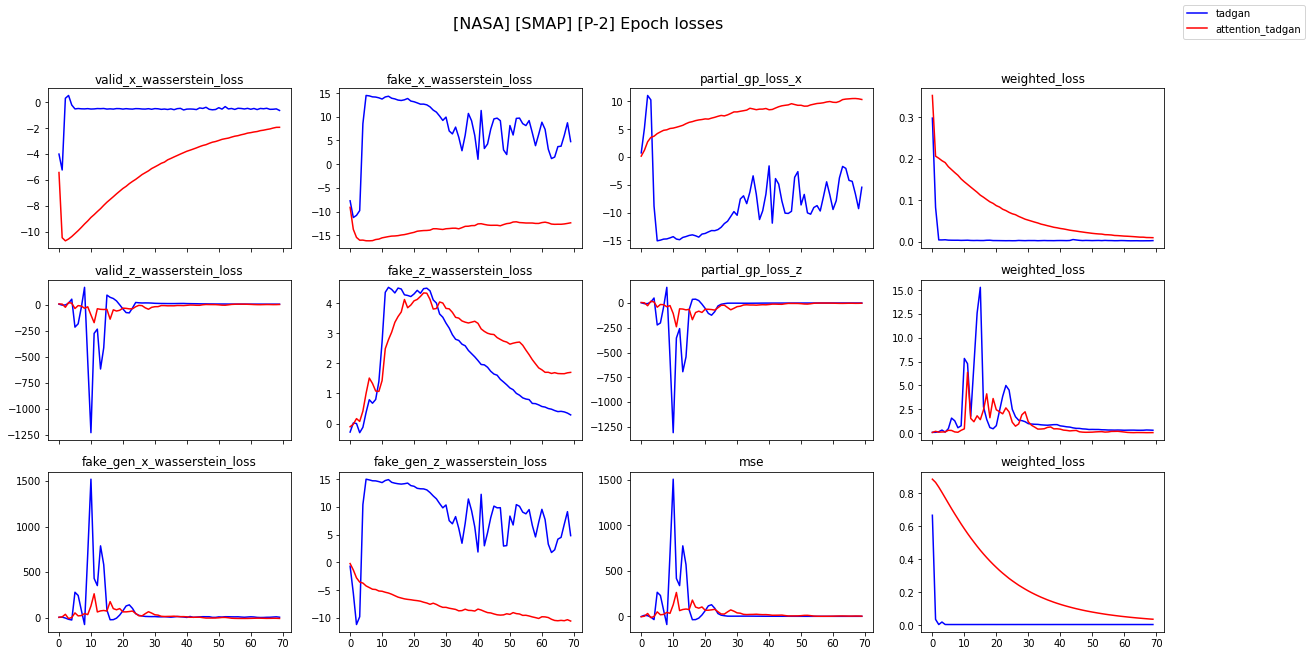

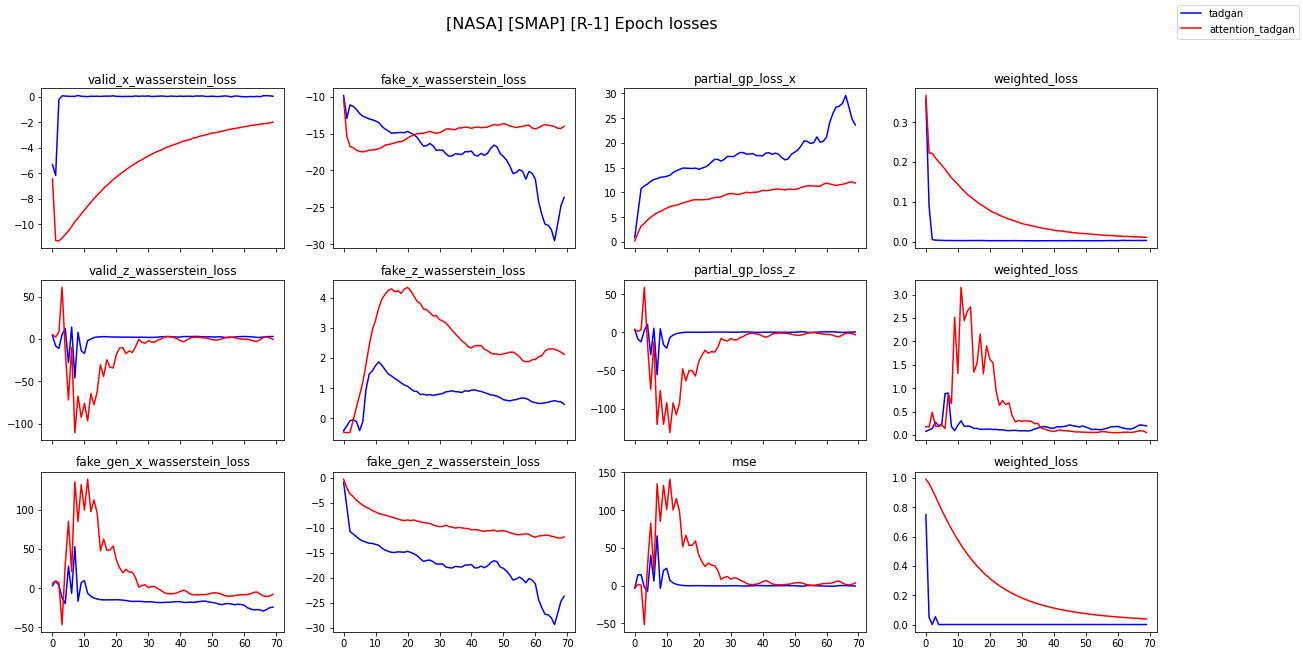

In [4]:
source = 'NASA'
dataset = 'SMAP'
columns = ['source', 'dataset', 'signal', 'ground_truth', 'tadgan_pp', 'tadgan_cm', 'attention_tadgan_pp', 'attention_tadgan_cm']

signals = AnomalyDataset.get_signals(source, dataset)
signals_summary = []

for signal in tqdm(signals):
    print(signal)
    try:
        model_epoch_loss = []
        model_epoch_loss.append(get_epoch_loss(source, dataset, signal, TadGAN.model_name))
        model_epoch_loss.append(get_epoch_loss(source, dataset, signal, AttentionTadGAN.model_name))

        output_directory = os.path.join(REPORTS_DIRECTORY, source, dataset, signal)
        if not os.path.exists(output_directory):
            os.makedirs(output_directory)
        plot_losses(model_epoch_loss[0], model_epoch_loss[1], output_directory)

        anomaly_dataset = AnomalyDataset.load(source, dataset, signal)
        summary = [source, dataset, signal]
        summary.append(anomaly_dataset.test.anomalies.values)
        summary.extend(calculate_confusion_matrix(
            TadGAN.model_name, 
            anomaly_dataset.test.anomalies,
            anomaly_dataset.test.y_processed, 
            list(anomaly_dataset.test.index)
        ))
        summary.extend(calculate_confusion_matrix(
            AttentionTadGAN.model_name, 
            anomaly_dataset.test.anomalies,
            anomaly_dataset.test.y_processed, 
            list(anomaly_dataset.test.index)
        ))
        signals_summary.append(summary)
    except:
        print('failed', signal)

In [5]:
summary_df = pd.DataFrame(signals_summary, columns=columns)
summary_df.to_csv(os.path.join(REPORTS_DIRECTORY, source, dataset, 'summary.csv'), index=False)

In [6]:
summary_df

source dataset signal                                ground_truth  \
0    NASA    SMAP    A-9                              [[4569, 8433]]   
1    NASA    SMAP    A-7                              [[6200, 8600]]   
2    NASA    SMAP    E-8                              [[5400, 6022]]   
3    NASA    SMAP    G-2                              [[4030, 4070]]   
4    NASA    SMAP    E-6                              [[5610, 5675]]   
5    NASA    SMAP    E-1                [[5000, 5030], [5610, 6086]]   
6    NASA    SMAP    A-6                              [[1890, 1930]]   
7    NASA    SMAP    A-1                              [[4690, 4774]]   
8    NASA    SMAP    A-8                              [[4569, 8374]]   
9    NASA    SMAP    E-7                              [[5394, 5674]]   
10   NASA    SMAP    G-3                              [[4200, 4250]]   
11   NASA    SMAP    G-4                              [[4690, 4720]]   
12   NASA    SMAP    E-9                              [[5550, 5900]]   
13   NASA    SMAP    S-1                              [[5300, 5747]]   
14   NASA    SMAP    D-5                              [[4800, 4850]]   
15   NASA    SMAP    D-2                              [[4319, 8536]]   
16   NASA    SMAP    F-1                              [[5392, 5492]]   
17   NASA    SMAP    D-3                              [[5225, 8500]]   
18   NASA    SMAP    D-4                              [[5225, 8472]]   
19   NASA    SMAP    B-1                              [[5060, 5130]]   
20   NASA    SMAP   D-11                              [[4270, 4330]]   
21   NASA    SMAP    P-7                              [[4950, 6600]]   
22   NASA    SMAP   E-11                [[5000, 5050], [5614, 5857]]   
23   NASA    SMAP    T-1                [[2399, 3898], [6550, 6585]]   
24   NASA    SMAP    P-1  [[2149, 2349], [4536, 4844], [3539, 3779]]   
25   NASA    SMAP   E-10                [[5000, 5050], [5601, 5871]]   
26   NASA    SMAP    G-1                              [[4770, 4890]]   
27   NASA    SMAP    G-6                              [[5600, 5700]]   
28   NASA    SMAP    E-2                              [[5598, 6995]]   
29   NASA    SMAP    E-5                              [[5600, 5920]]   
30   NASA    SMAP    A-4                              [[4550, 4660]]   
31   NASA    SMAP    A-3                              [[4575, 4760]]   
32   NASA    SMAP    E-4                              [[5450, 8261]]   
33   NASA    SMAP    E-3                              [[5094, 8306]]   
34   NASA    SMAP    G-7  [[3650, 3750], [5050, 5100], [7560, 7675]]   
35   NASA    SMAP    A-2                              [[4450, 4560]]   
36   NASA    SMAP    A-5                              [[2750, 2800]]   
37   NASA    SMAP   D-13                              [[5070, 5230]]   
38   NASA    SMAP    D-1                              [[5250, 8508]]   
39   NASA    SMAP    D-6                              [[4870, 4950]]   
40   NASA    SMAP    F-2                              [[5669, 8625]]   
41   NASA    SMAP    D-8                              [[4370, 4420]]   
42   NASA    SMAP    D-9                              [[6250, 7405]]   
43   NASA    SMAP    F-3                              [[5600, 5640]]   
44   NASA    SMAP    D-7                              [[4940, 7641]]   
45   NASA    SMAP   E-12                [[5610, 6141], [5000, 5050]]   
46   NASA    SMAP    T-2                              [[6840, 8624]]   
47   NASA    SMAP    P-4   [[950, 1080], [2150, 2350], [4770, 4880]]   
48   NASA    SMAP    P-3                              [[5401, 6736]]   
49   NASA    SMAP    T-3                [[2098, 2180], [5200, 5300]]   
50   NASA    SMAP   E-13  [[5309, 5410], [5600, 5640], [6449, 6569]]   
51   NASA    SMAP    P-2                              [[5300, 6420]]   
52   NASA    SMAP    R-1                              [[4510, 4590]]   

                                            tadgan_pp        tadgan_cm  \
0                                       

In [7]:
values = []
for i in summary_df.tadgan_cm:
    v = []
    for j in i:
        if j is None:
            v.append(0)
        else:
            v.append(j)
    values.append(v)
tadgan_cm = np.array(values).sum(axis=0)
print(tadgan_cm)

tn, fp, fn, tp = tadgan_cm

f1 = tp / (tp + .5 * (fp + fn))
f1

[ 0 34 21 46]


0.6258503401360545

In [8]:
values = []
for i in summary_df.attention_tadgan_cm:
    v = []
    for j in i:
        if j is None:
            v.append(0)
        else:
            v.append(j)
    values.append(v)
attnetion_tadgan_cm = np.array(values).sum(axis=0)
print(attnetion_tadgan_cm)

tn, fp, fn, tp = attnetion_tadgan_cm

f1 = tp / (tp + .5 * (fp + fn))
f1

[ 0 37 20 47]


0.6225165562913907